In [ ]:
!pip install pyspark
!pip install shap
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9331b53da54af2f23035dc9e3992f236d2d4c0db76ec5e24f7606a1091a808d1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=2092f9e3f4fb00ce99426b9cad169a032415f24e5ce0fc94a9cdacf51ef81a1f
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


# Importing libraries

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import shap

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, hour, dayofweek
from pyspark.sql.functions import col
from pyspark.ml import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# for Box-Cox Transformation
from scipy import stats

from mlxtend.preprocessing import minmax_scaling

# EDA

In [ ]:
csv_file = "sales_data.csv"

df_order = pd.read_csv(csv_file)

df_order.head(2)

DistributorCode               DistributorName  ClientCode  \
0             2715  Premier Agencies - HYDERABAD     3129643   
1             2715  Premier Agencies - HYDERABAD     1301969   

                                          ClientName  \
0  STAR MEDICAL STORE/HIRABAD/HIRABAD-HIRABAD-AZA...   
1  BHITAI MEDICAL STORE/BIHAR COLONY HOSRI/HOSRI-...   

                                    BrickName  Product          SKU  \
0  HIRABAD-HIRABAD-AZAD MEEZAN MASJID HIRABAD  Prod-NS  Prod-NS-Tab   
1              HOSRI-HOSRI-BIHAR COLONY HOSRI  Prod-NS  Prod-NS-Tab   

  InvoiceDate  Units  Bonus  Discount  ValueNp  
0    4/1/2017      1      0       0.0    97.75  
1    4/1/2017      3      0       0.0   293.25

In [ ]:
print("Sales Overview:\n")
df_order.info()
df_order.shape

Sales Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290514 entries, 0 to 290513
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DistributorCode  290514 non-null  int64  
 1   DistributorName  290514 non-null  object 
 2   ClientCode       290514 non-null  int64  
 3   ClientName       290514 non-null  object 
 4   BrickName        290514 non-null  object 
 5   Product          290514 non-null  object 
 6   SKU              290514 non-null  object 
 7   InvoiceDate      290514 non-null  object 
 8   Units            290514 non-null  int64  
 9   Bonus            290514 non-null  int64  
 10  Discount         290514 non-null  float64
 11  ValueNp          290514 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 26.6+ MB


(290514, 12)

In [ ]:
stats = df_order.describe()

stats

DistributorCode    ClientCode          Units     Bonus       Discount  \
count    290514.000000  2.905140e+05  290514.000000  290514.0  290514.000000   
mean       3092.859570  1.689782e+06       5.260294       0.0       3.092387   
std         583.352451  6.825756e+05      13.821555       0.0      60.970796   
min        2715.000000  1.074279e+06    -125.000000       0.0   -1075.272000   
25%        2715.000000  1.302933e+06       1.000000       0.0       0.000000   
50%        2718.000000  1.383455e+06       2.000000       0.0       0.000000   
75%        3996.000000  1.671884e+06       5.000000       0.0       0.000000   
max        3996.000000  4.310143e+06     800.000000       0.0    3910.000000   

             ValueNp  
count  290514.000000  
mean      950.947665  
std      2393.026072  
min    -25500.000000  
25%       195.500000  
50%       351.900000  
75%       821.100000  
max     98940.000000

1. **DistributorCode & DistributorName:** These represent the unique identifier and the name of the distributor, respectively.

2. **ClientCode & ClientName:** These represent the unique identifier and the name of the client or store where the products were sold. The client name also seems to contain location or categorization information.

3. **BrickName:** This appears to be a more detailed location or category identifier related to the client.

4. **Product & SKU:** These pertain to the product details. While the "Product" column gives a generic product name, the "SKU" (Stock Keeping Unit) provides a more granular product identifier.

5. **InvoiceDate:** The date when the transaction took place.

6. **Units:** Represents the quantity of the product sold in the transaction. Negative values might indicate returns.

7. **Bonus:** Represents any additional units or items given as a bonus. In this dataset, no bonuses were given.

8. **Discount:** Represents the discount given on the product. In this dataset, no discounts were applied.

9. **ValueNp:** Represents the total value or revenue from the sale in a currency. This might be the product of units sold and the price per unit, adjusted for any returns or discounts.

## Product wise analysis

In [ ]:
product_distributor_analysis = df_order.groupby(['Product', 'DistributorName']).size().reset_index(name='Count')
product_distributor_analysis.head()

Product               DistributorName  Count
0  Prod-AC  Premier Agencies - HYDERABAD   1762
1  Prod-AC   Premier Agencies - PESHAWAR   2136
2  Prod-AC     Premier Agencies - SUKKUR   1075
3  Prod-EF  Premier Agencies - HYDERABAD   3731
4  Prod-EF   Premier Agencies - PESHAWAR   4689

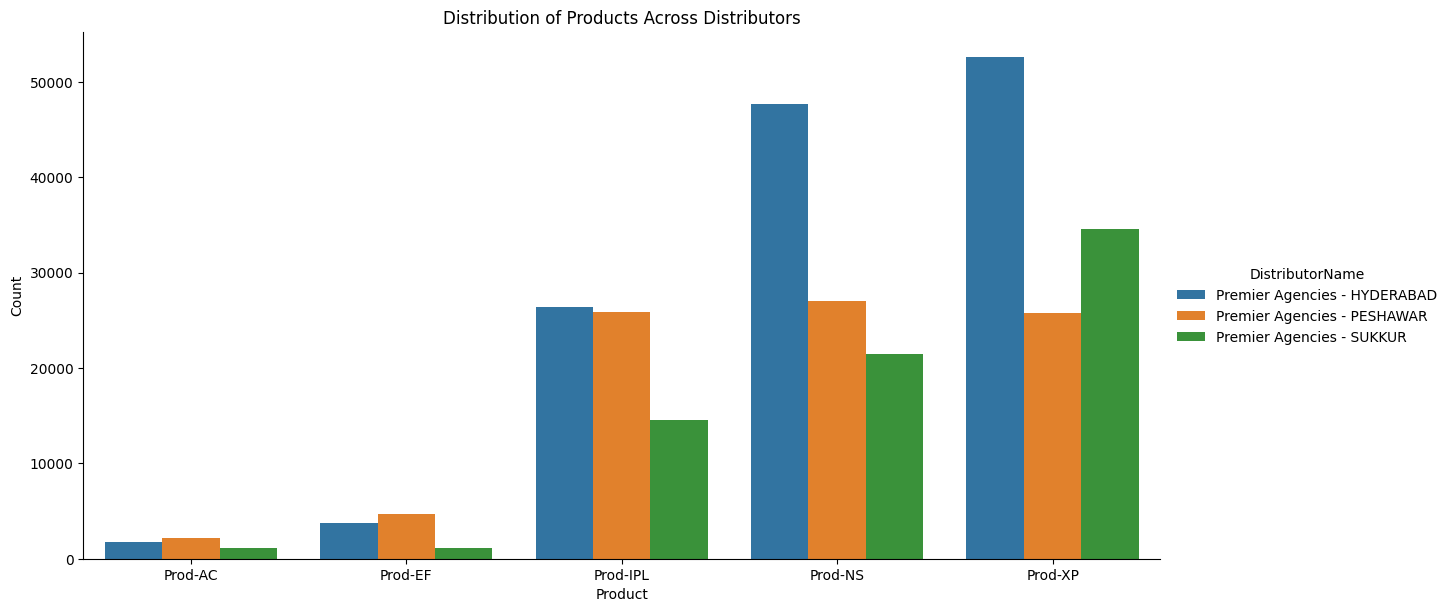

In [ ]:

sns.catplot(data=product_distributor_analysis, x='Product', y='Count', hue='DistributorName', kind='bar', height=6, aspect=2)
plt.title('Distribution of Products Across Distributors')
plt.show()

In [ ]:
# Extract city from DistributorName
df_order['City'] = df_order['DistributorName'].str.split('-').str[-1].str.strip()

# few rows
df_order[['DistributorName', 'City']].tail()

DistributorName    City
290509  Premier Agencies - SUKKUR  SUKKUR
290510  Premier Agencies - SUKKUR  SUKKUR
290511  Premier Agencies - SUKKUR  SUKKUR
290512  Premier Agencies - SUKKUR  SUKKUR
290513  Premier Agencies - SUKKUR  SUKKUR

In [ ]:
# city wise product analysis
product_city_analysis = df_order.groupby(['Product', 'City']).size().reset_index(name='Count')
product_city_analysis.head()

Product       City  Count
0  Prod-AC  HYDERABAD   1762
1  Prod-AC   PESHAWAR   2136
2  Prod-AC     SUKKUR   1075
3  Prod-EF  HYDERABAD   3731
4  Prod-EF   PESHAWAR   4689

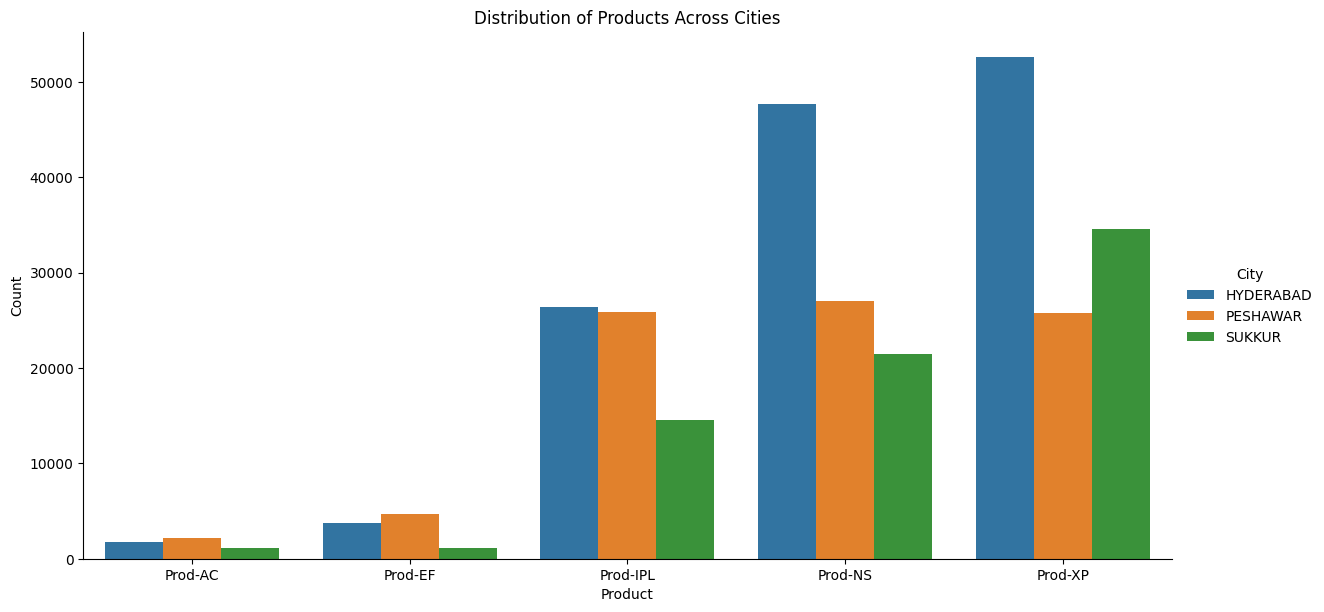

In [ ]:
sns.catplot(data=product_city_analysis, x='Product', y='Count', hue='City', kind='bar', height=6, aspect=2)
plt.title('Distribution of Products Across Cities')
plt.show()

In [ ]:
# brick wise product analysis
product_brick_analysis = df_order.groupby(['Product', 'BrickName']).size().reset_index(name='Count')
product_brick_analysis.head(5)

Product                                          BrickName  Count
0  Prod-AC  ADVANI GALI-ADVANI GALI-CHIGGA PAN STREET ADVA...      2
1  Prod-AC  ADVANI GALI-ADVANI GALI-NOORANI MASJID ADVANI ...      3
2  Prod-AC  ADVANI GALI-ADVANI GALI-SHAH NOORANI MARKET AD...     12
3  Prod-AC  AFGHAN COLONY-AFGHAN COLONY-AFGHAN COLONY CANA...      3
4  Prod-AC       AFGHAN COLONY-CHARSADA ROAD-BACHA KHAN CHOWK      3

In [ ]:
import plotly.express as px

fig = px.bar(product_brick_analysis, x='Product', y='Count', color='BrickName',
             labels={'Count': 'Count', 'Product': 'Product', 'BrickName': 'Brick Name'},
             title='Distribution of Products Across Bricks')

fig.update_layout(height=600, width=1200)

fig.show()


## Distributor wise analysis

In [ ]:
# Product Sale for Each Distributor:
distributor_product_analysis = df_order.groupby(['DistributorName', 'Product']).size().reset_index(name='SalesCount')
distributor_product_analysis.head()

DistributorName   Product  SalesCount
0  Premier Agencies - HYDERABAD   Prod-AC        1762
1  Premier Agencies - HYDERABAD   Prod-EF        3731
2  Premier Agencies - HYDERABAD  Prod-IPL       26353
3  Premier Agencies - HYDERABAD   Prod-NS       47700
4  Premier Agencies - HYDERABAD   Prod-XP       52601

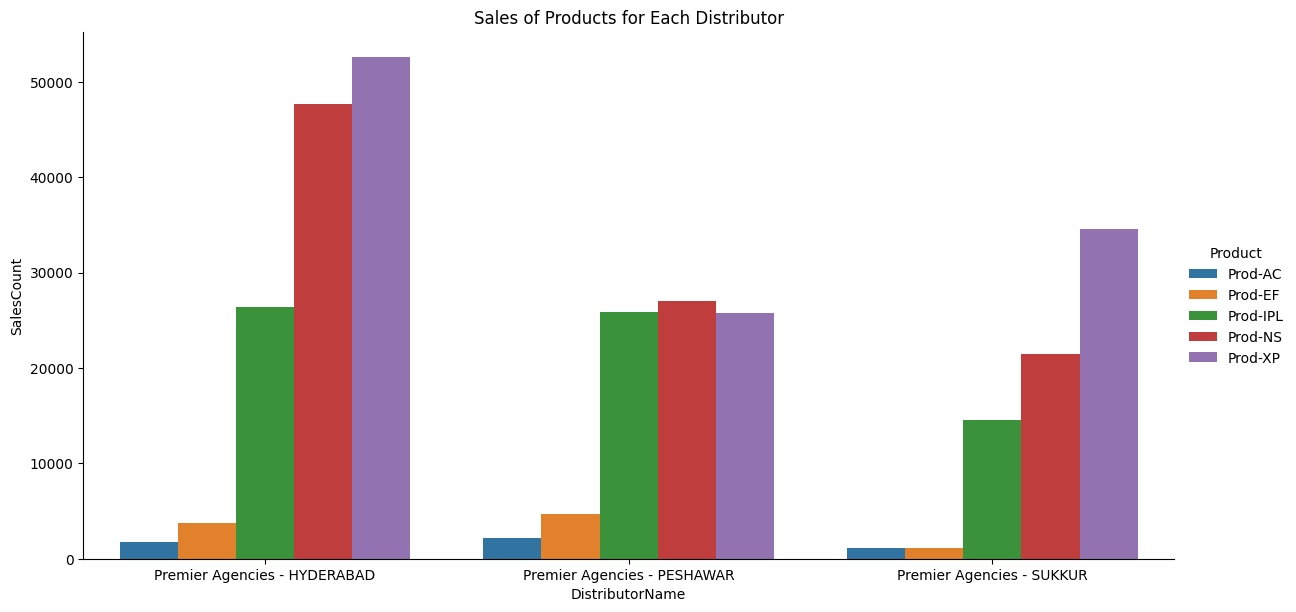

In [ ]:
sns.catplot(data=distributor_product_analysis, x='DistributorName', y='SalesCount', hue='Product', kind='bar', height=6, aspect=2)
plt.title('Sales of Products for Each Distributor')
plt.show()

In [ ]:
# Brick Wise Analysis for Each Distributor:
distributor_brick_analysis = df_order.groupby(['DistributorName', 'BrickName']).size().reset_index(name='Count')
distributor_brick_analysis.head()

DistributorName  \
0  Premier Agencies - HYDERABAD   
1  Premier Agencies - HYDERABAD   
2  Premier Agencies - HYDERABAD   
3  Premier Agencies - HYDERABAD   
4  Premier Agencies - HYDERABAD   

                                           BrickName  Count  
0  ADVANI GALI-ADVANI GALI-CHIGGA PAN STREET ADVA...   1354  
1  ADVANI GALI-ADVANI GALI-NOORANI MASJID ADVANI ...   1171  
2  ADVANI GALI-ADVANI GALI-SHAH NOORANI MARKET AD...   1864  
3   ADVANI GALI-CHOTKI GITTI-MAIN CHOWK CHOTKI GITTI    138  
4                 AFANDI TOWN-AFANDI TOWN-3,NO TALAB     44

In [ ]:

fig = px.bar(distributor_brick_analysis, x='DistributorName', y='Count', color='BrickName',
             labels={'Count': 'Count', 'DistributorName': 'Distributor Name', 'BrickName': 'Brick Name'},
             title='Brick Wise Analysis for Each Distributor')
fig.update_layout(height=600, width=1200)

fig.show()


In [ ]:
df_order['Year'] = pd.to_datetime(df_order['InvoiceDate']).dt.year

In [ ]:
# Year Wise Analysis for Each Distributor:
distributor_year_analysis = df_order.groupby(['DistributorName', 'Year']).size().reset_index(name='SalesCount')
distributor_year_analysis.head()

DistributorName  Year  SalesCount
0  Premier Agencies - HYDERABAD  2016       30348
1  Premier Agencies - HYDERABAD  2017       67791
2  Premier Agencies - HYDERABAD  2018       34008
3   Premier Agencies - PESHAWAR  2016       19299
4   Premier Agencies - PESHAWAR  2017       43032

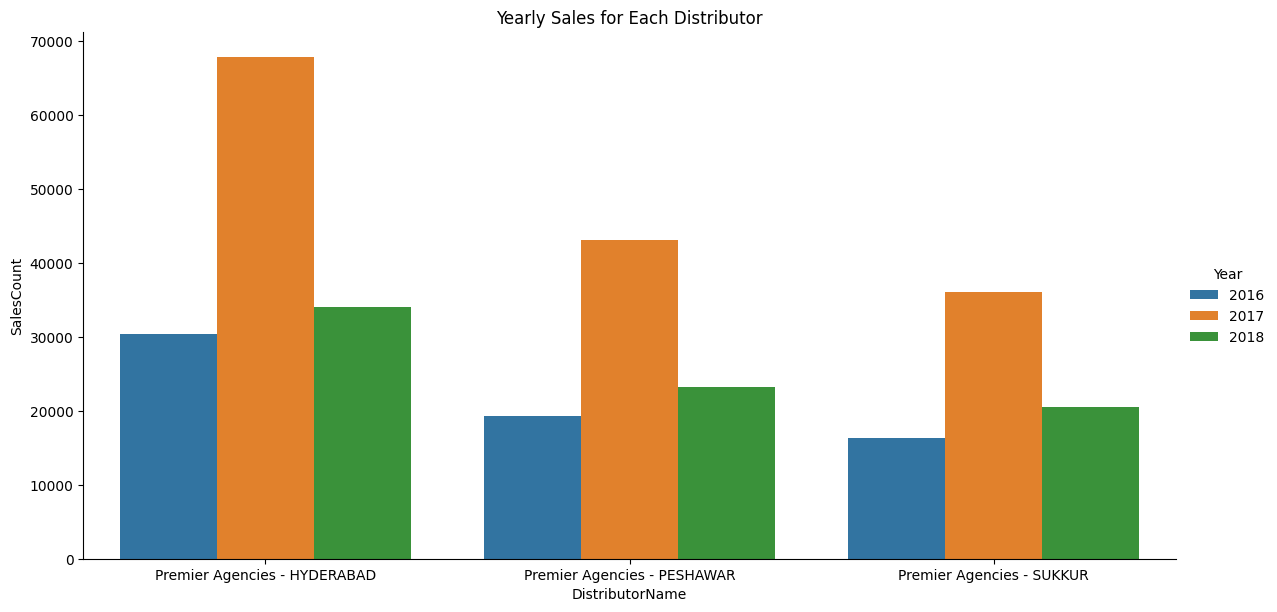

In [ ]:
sns.catplot(data=distributor_year_analysis, x='DistributorName', y='SalesCount', hue='Year', kind='bar', height=6, aspect=2)
plt.title('Yearly Sales for Each Distributor')
plt.show()

## Brick wise analysis

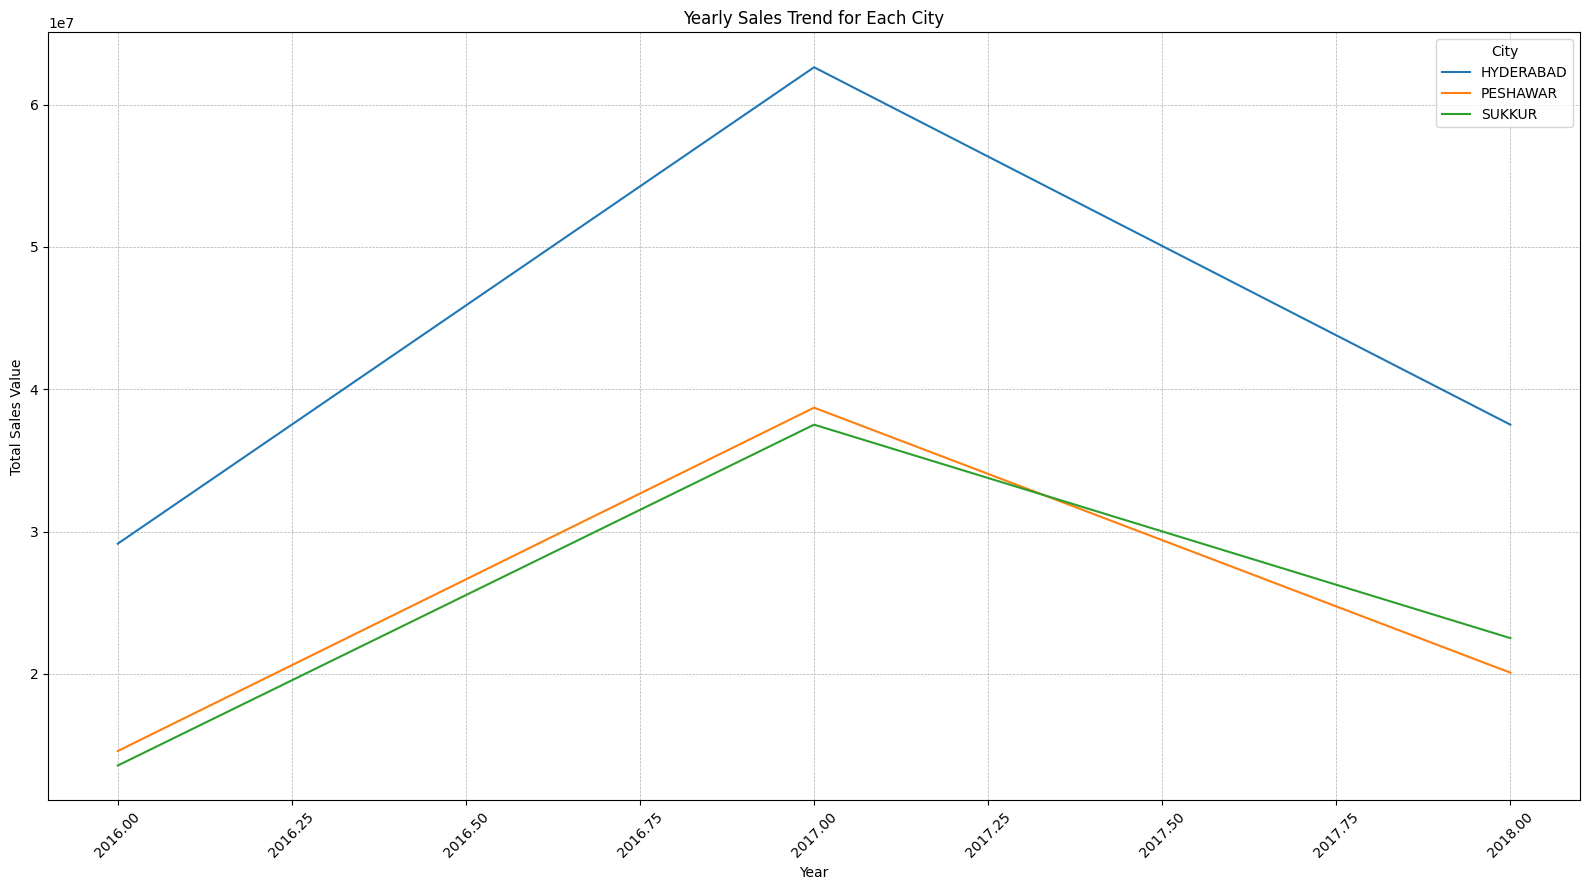

In [ ]:

df_order['InvoiceDate'] = pd.to_datetime(df_order['InvoiceDate'])

df_order['City'] = df_order['DistributorName'].str.split('-').str[-1].str.strip()

df_order['Year'] = df_order['InvoiceDate'].dt.year

# Sales Trends for each city
city_sales_trend = df_order.groupby(['City', 'Year']).agg(TotalSales=('ValueNp', 'sum')).reset_index()

plt.figure(figsize=(16, 9))
sns.lineplot(data=city_sales_trend, x='Year', y='TotalSales', hue='City')
plt.title('Yearly Sales Trend for Each City')
plt.ylabel('Total Sales Value')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:

# Top Bricks by Sales
df_order['InvoiceDate'] = pd.to_datetime(df_order['InvoiceDate'])

top_bricks = df_order.groupby('BrickName')['ValueNp'].sum().reset_index().nlargest(10, 'ValueNp')

fig = px.bar(top_bricks, x='BrickName', y='ValueNp',
             labels={'ValueNp': 'Total Sales Value', 'BrickName': 'Brick Name'},
             title='Top 10 Bricks by Sales')

fig.show()


In [ ]:
# Group by BrickName and aggregate the relevant columns
brick_summary = df_order.groupby('BrickName').agg({
    'Units': 'sum',
    'Bonus': 'sum',
    'Discount': 'sum',
    'ValueNp': 'sum'
}).reset_index()

# Sort the dataframe by ValueNp in descending order for better visualization
brick_summary = brick_summary.sort_values(by='ValueNp', ascending=False)

# Display the first few rows of the brick summary
brick_summary.head()

BrickName  Units  Bonus  \
352            JAIL ROAD-JAIL ROAD-MAIN ROAD JAIL ROAD  47489      0   
617                       SADDAR-SADDAR-DR.LINE SADDAR  41233      0   
345   HYDERABAD OUTSTATION-THATTHA-SHAHI BAZAR THATTHA  40182      0   
393  LATIFABAD-LATIFABAD # 10-MAIN BAZAR LATIFABAD ...  30632      0   
215                       HAYATABAD-KHYBER BAZAR-L.R.H  41369      0   

       Discount       ValueNp  
352       0.000  1.010533e+07  
617       0.000  8.777376e+06  
345  209045.853  6.870773e+06  
393       0.000  6.492954e+06  
215   49119.908  6.202930e+06

In [ ]:
def get_top_bricks(df, group_by_column, n):
    sales_per_brick = df.groupby(['BrickName', group_by_column])['Units'].sum().reset_index()
    total_sales = df.groupby(group_by_column)['Units'].sum().reset_index()

    top_bricks = (sales_per_brick
                  .groupby(group_by_column)
                  .apply(lambda x: x.nlargest(n, 'Units'))
                  .reset_index(drop=True)
                  .sort_values(by=['Units'], ascending=False))  # Sort by Units in descending order

    merged_data = pd.merge(top_bricks, total_sales, on=group_by_column, suffixes=('_Top_Brick', '_Total'))

    return merged_data

In [ ]:
merged_distributor = get_top_bricks(df_order, 'DistributorName', 1)
merged_product = get_top_bricks(df_order, 'Product', 3)  # Change 1 to 3 for top 3 products


In [ ]:
import pandas as pd
import plotly.express as px

product_sales = df_order.groupby(['BrickName', 'Product'])['Units'].sum().reset_index()
top_bricks = product_sales.groupby('Product').apply(lambda x: x.nlargest(5, 'Units')).reset_index(drop=True)

fig_productwise = px.bar(top_bricks,
                         x='BrickName',
                         y='Units',
                         color='Product',
                         title="Top Bricks per Product based on Sales",
                         labels={'BrickName': 'Brick', 'Units': 'Total Sales'},
                         template="plotly_white",
                         height=800,
                         text='BrickName',
                         animation_frame='Product')

fig_productwise.update_layout(xaxis=dict(tickangle=-45))

fig_productwise.show()


In [ ]:
# Visualizing
distributor_sales = df_order.groupby(['BrickName', 'DistributorName'])['Units'].sum().reset_index()

top_bricks = distributor_sales.groupby('DistributorName').apply(lambda x: x.nlargest(5, 'Units')).reset_index(drop=True)
fig_distributorwise = px.bar(top_bricks,
                             x='BrickName',
                             y='Units',
                             color='DistributorName',
                             title="Top Bricks per Distributor based on Sales",
                             labels={'BrickName': 'Brick', 'Units': 'Total Sales'},
                             template="plotly_white",
                             height=600)
fig_distributorwise.update_layout(xaxis=dict(tickangle=-45))
fig_distributorwise.show()


# Trend over time

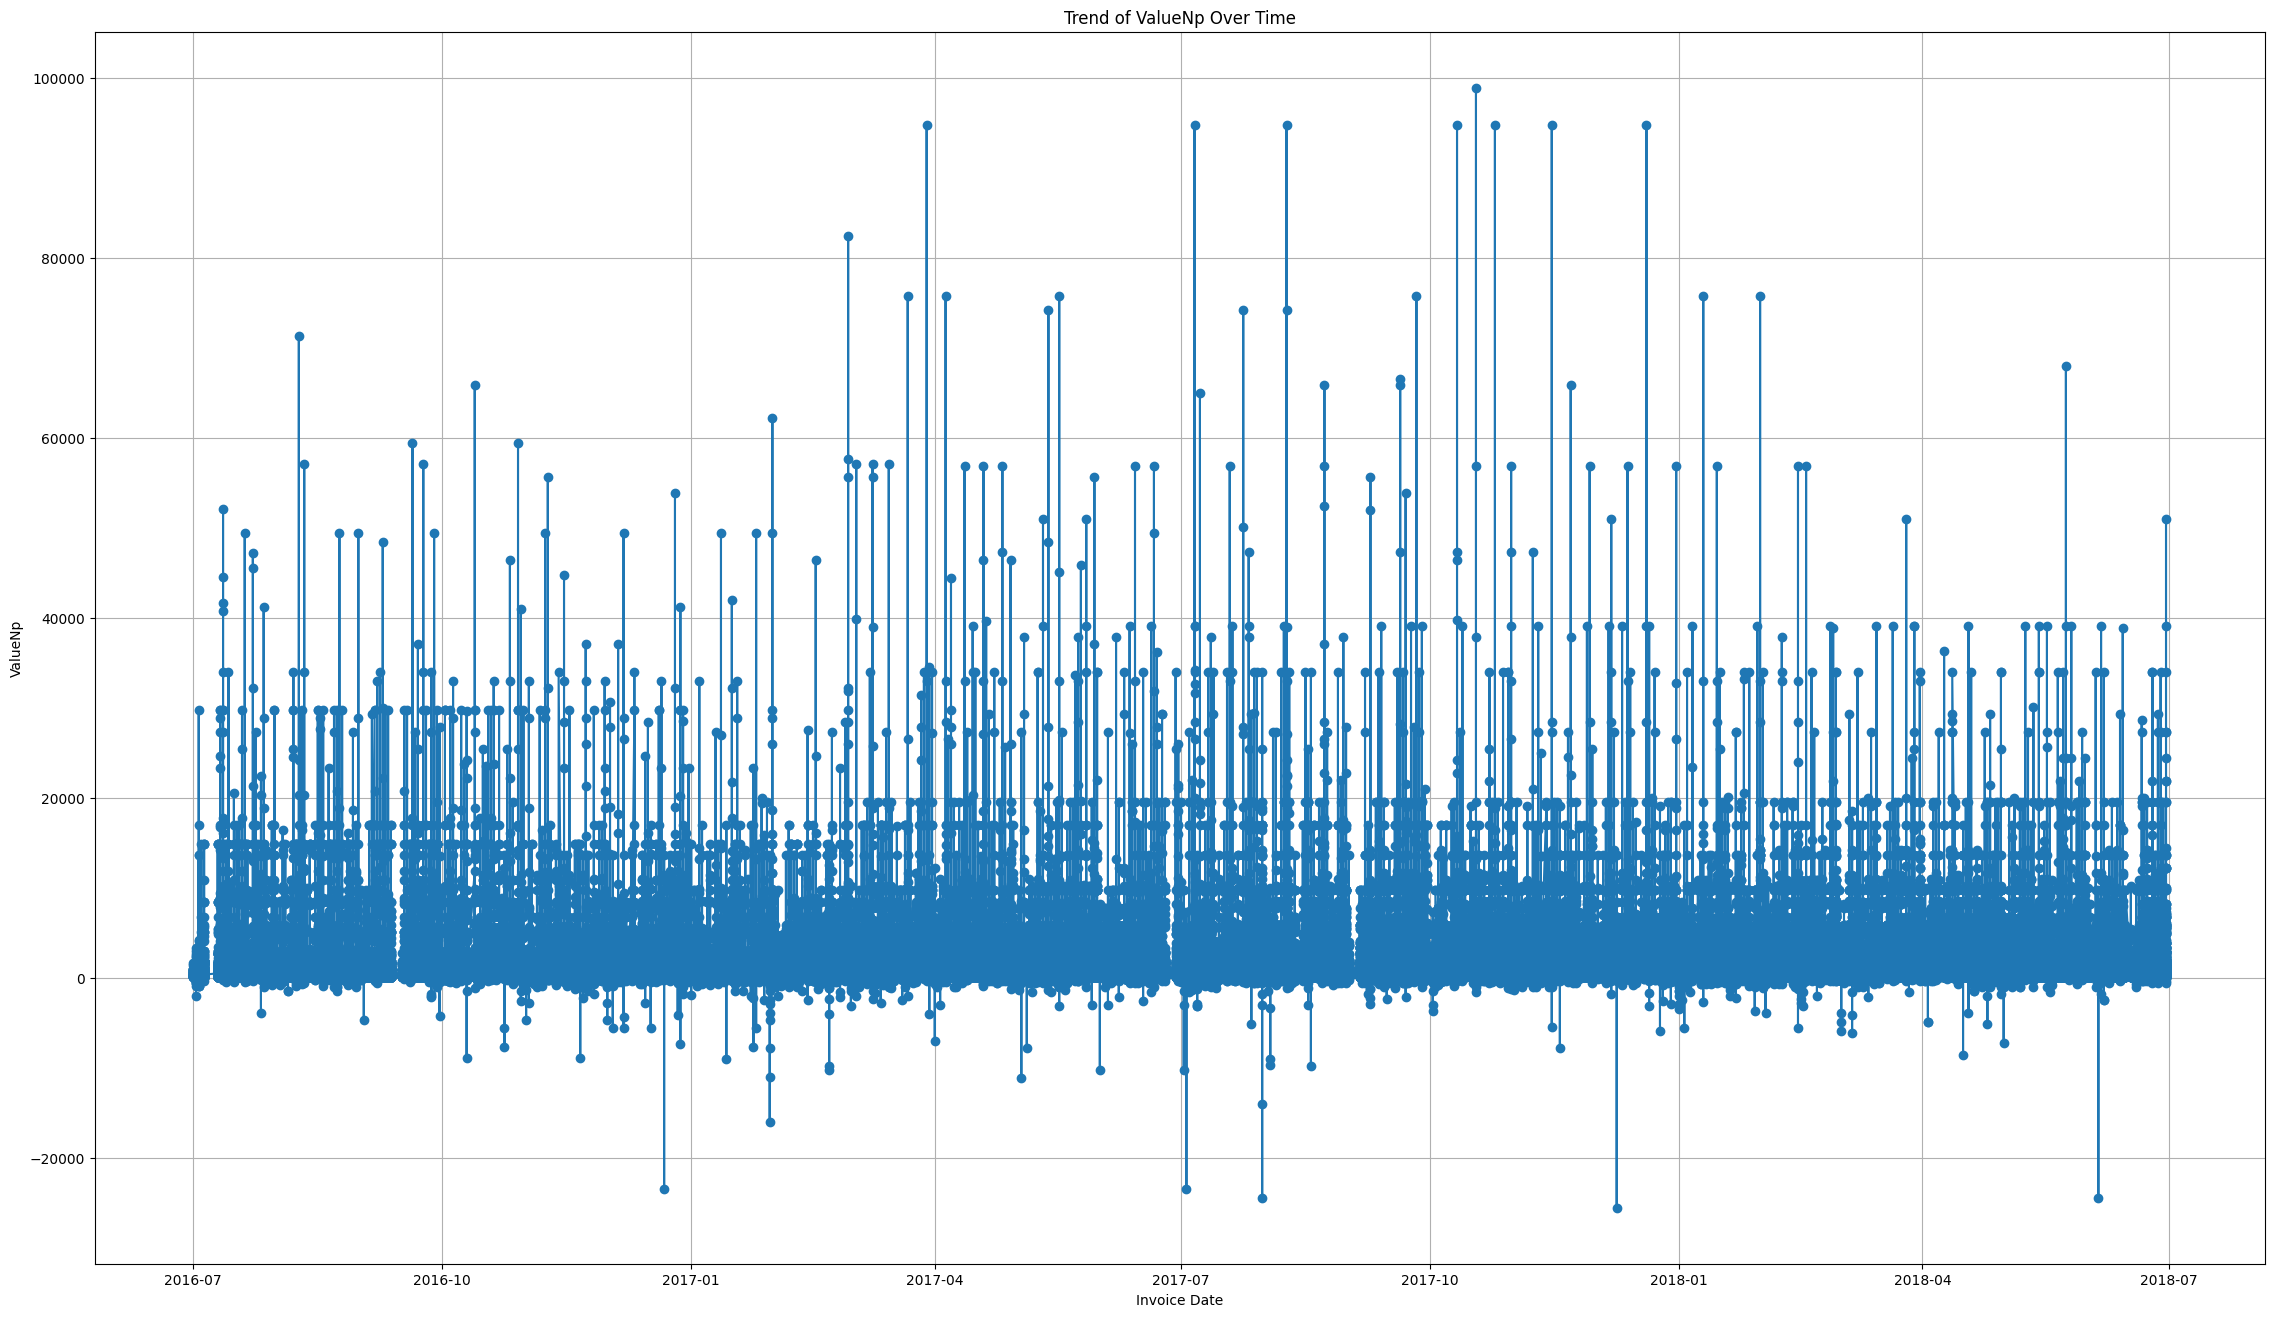

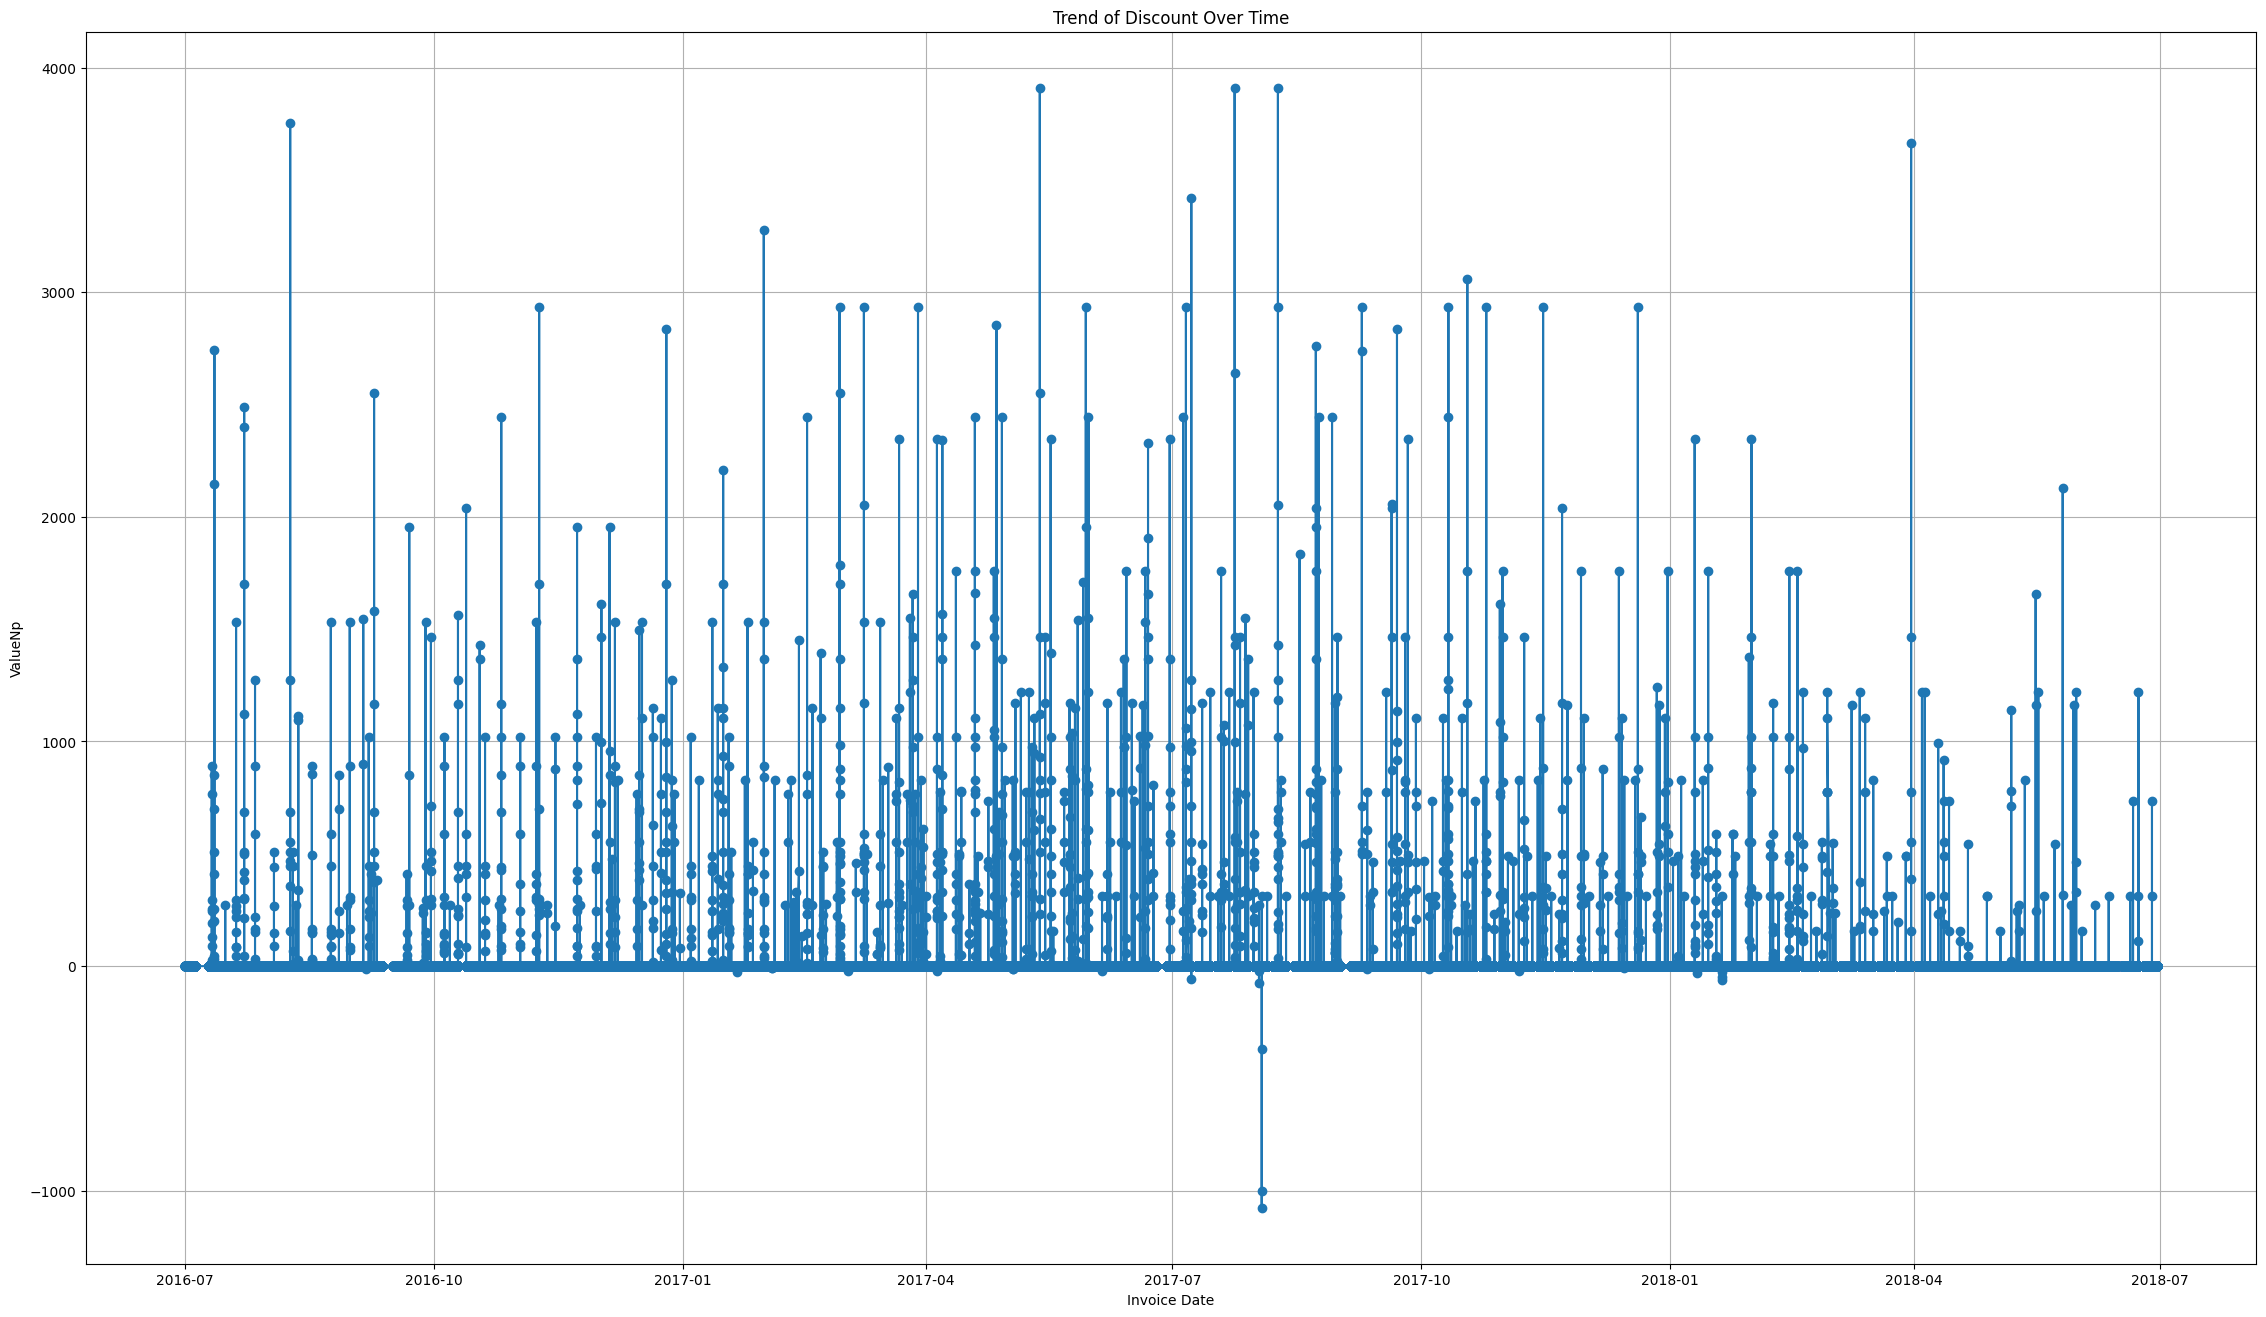

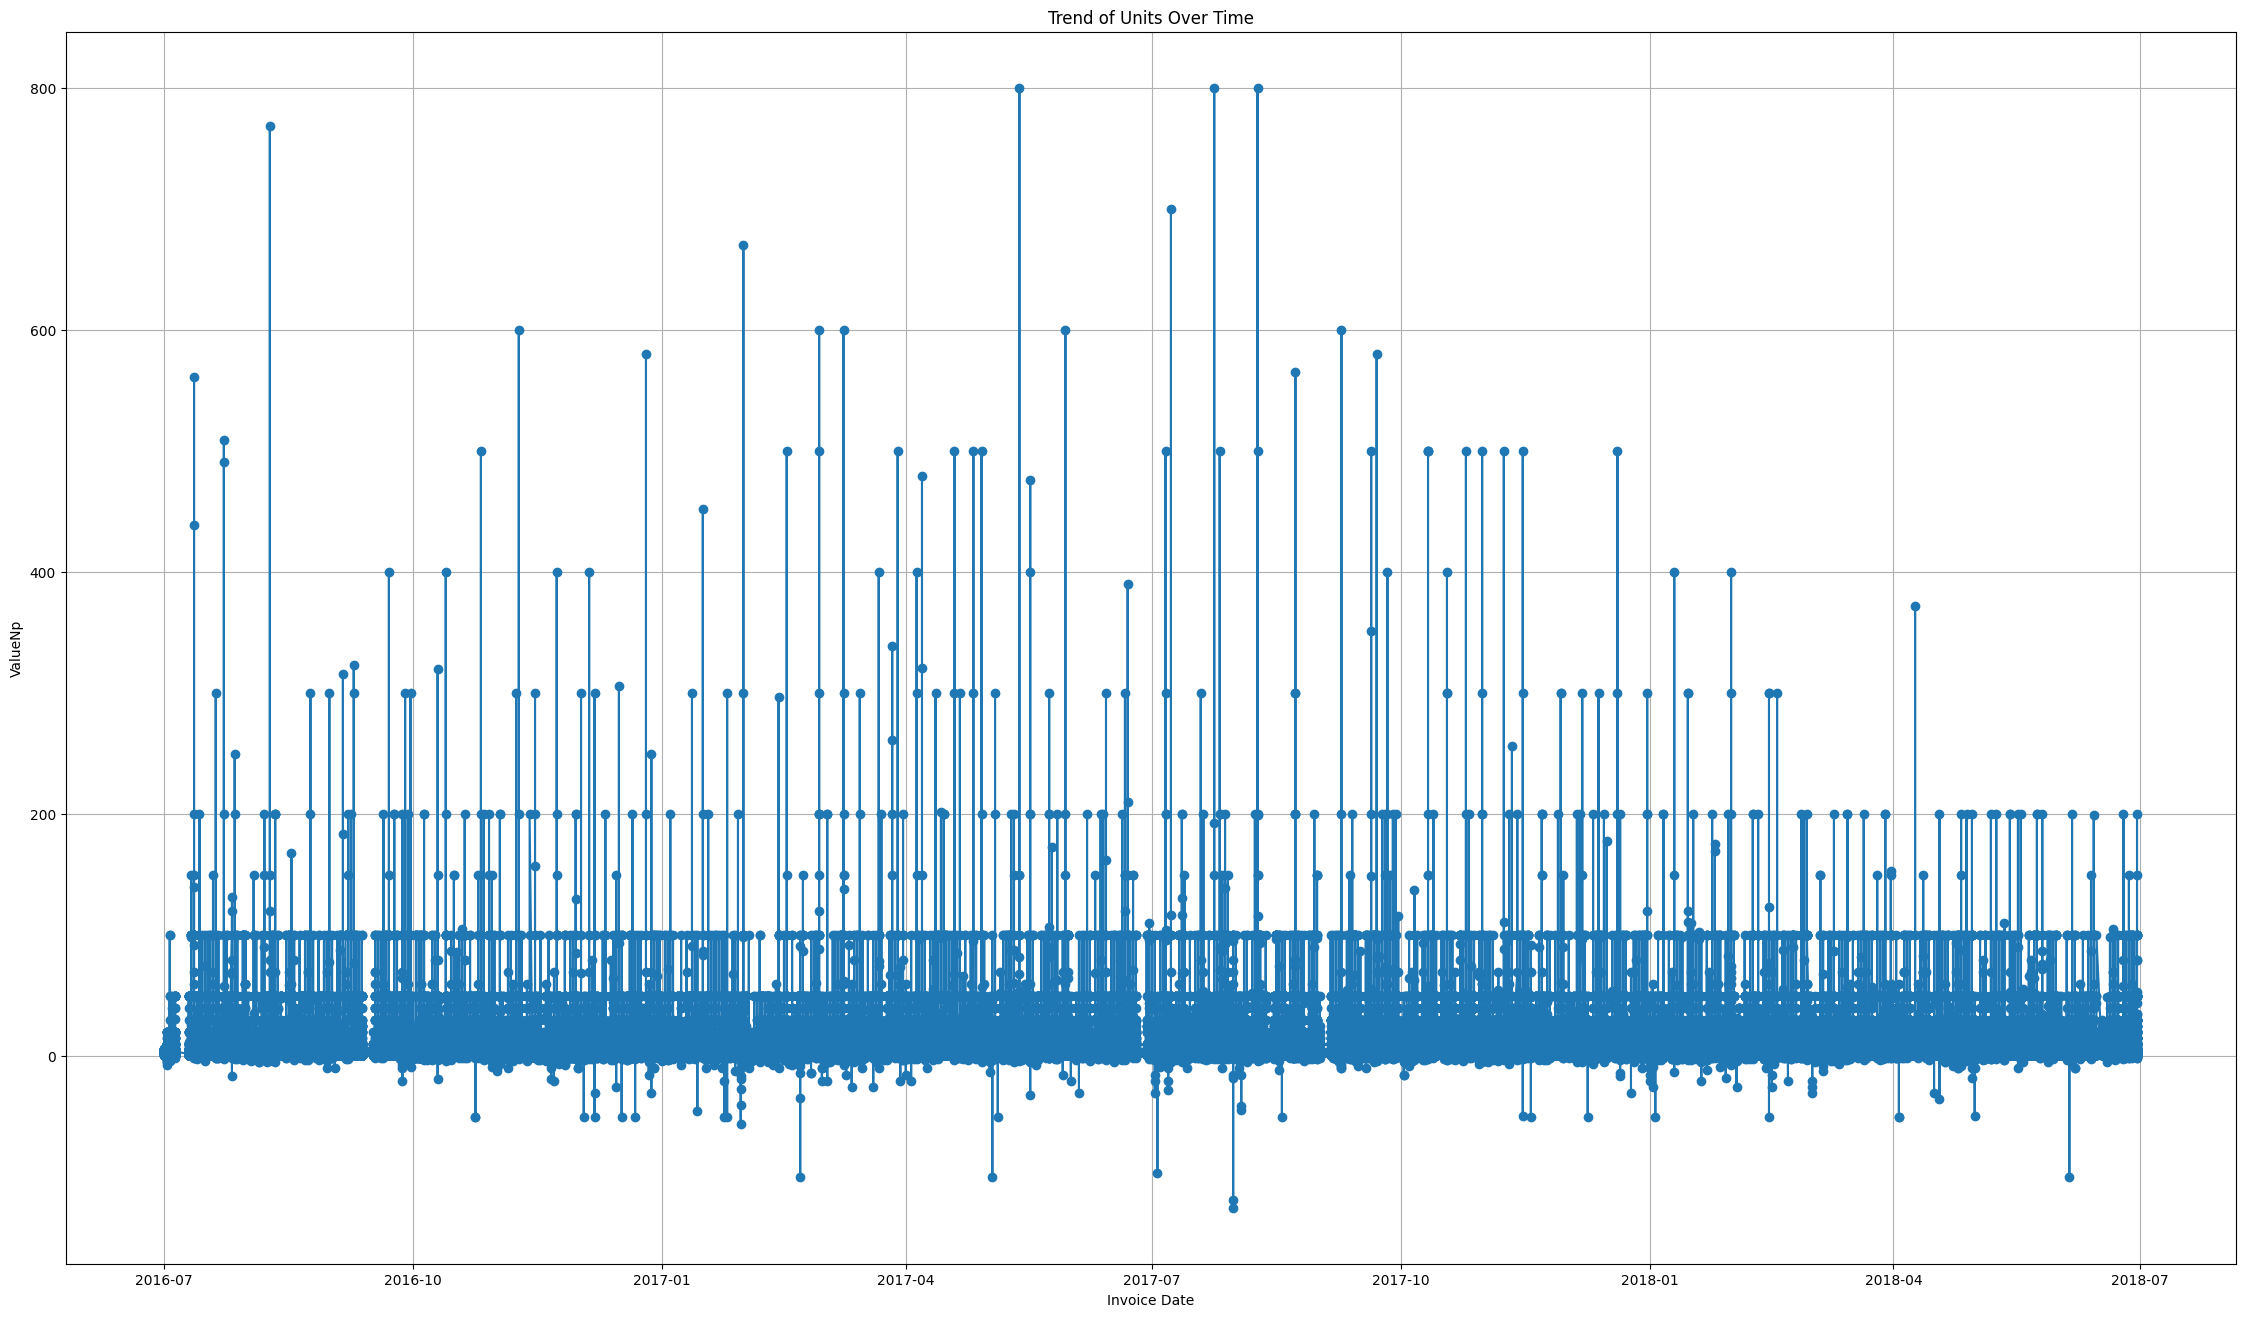

In [ ]:

# Convert 'InvoiceDate' to datetime format
df_order['InvoiceDate'] = pd.to_datetime(df_order['InvoiceDate'])

# Sort the DataFrame by 'InvoiceDate'
df_order.sort_values('InvoiceDate', inplace=True)

# Create a time series plot
plt.figure(figsize=(28, 16))
plt.plot(df_order['InvoiceDate'], df_order['ValueNp'], marker='o', linestyle='-')
plt.title('Trend of ValueNp Over Time')
plt.xlabel('Invoice Date')
plt.ylabel('ValueNp')
plt.grid(True)
plt.show()

# Create a time series plot
plt.figure(figsize=(28, 16))
plt.plot(df_order['InvoiceDate'], df_order['Discount'], marker='o', linestyle='-')
plt.title('Trend of Discount Over Time')
plt.xlabel('Invoice Date')
plt.ylabel('ValueNp')
plt.grid(True)
plt.show()

# Create a time series plot
plt.figure(figsize=(28, 16))
plt.plot(df_order['InvoiceDate'], df_order['Units'], marker='o', linestyle='-')
plt.title('Trend of Units Over Time')
plt.xlabel('Invoice Date')
plt.ylabel('ValueNp')
plt.grid(True)
plt.show()



# Trends in dataset

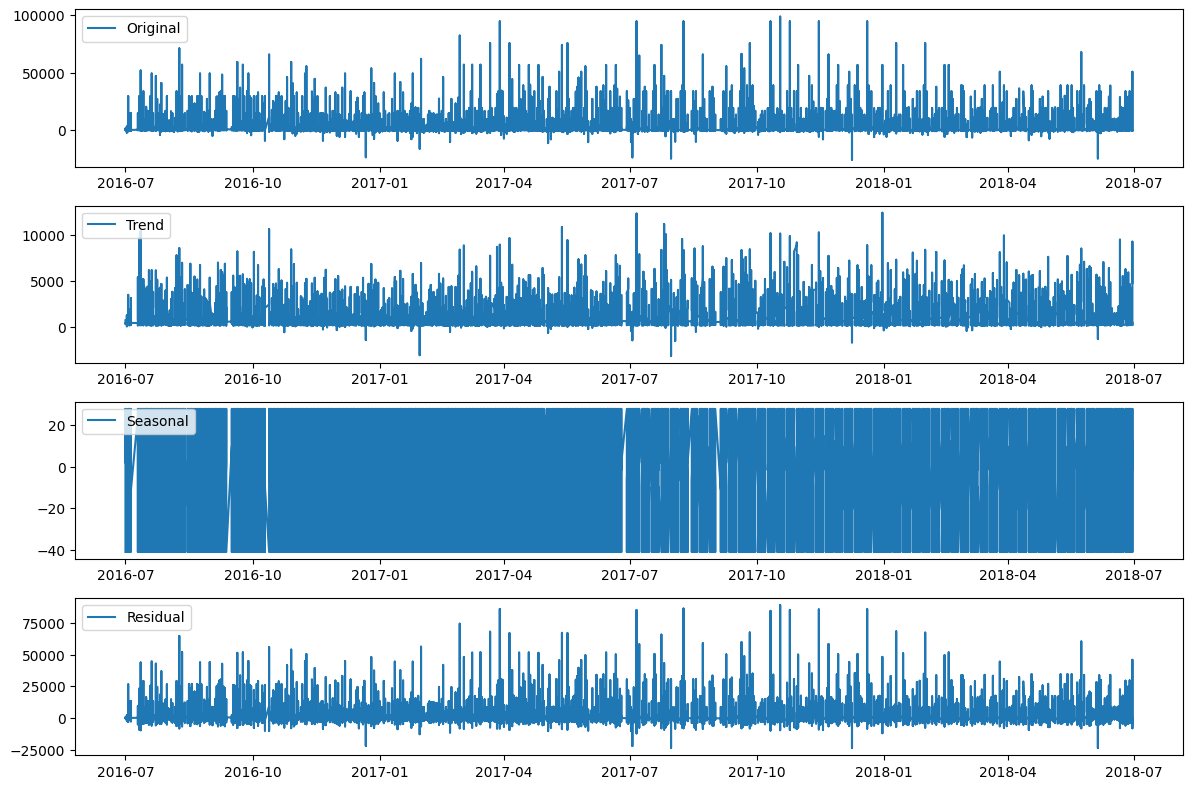

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(df_order['ValueNp'], model='additive', period=12)

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_order['ValueNp'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


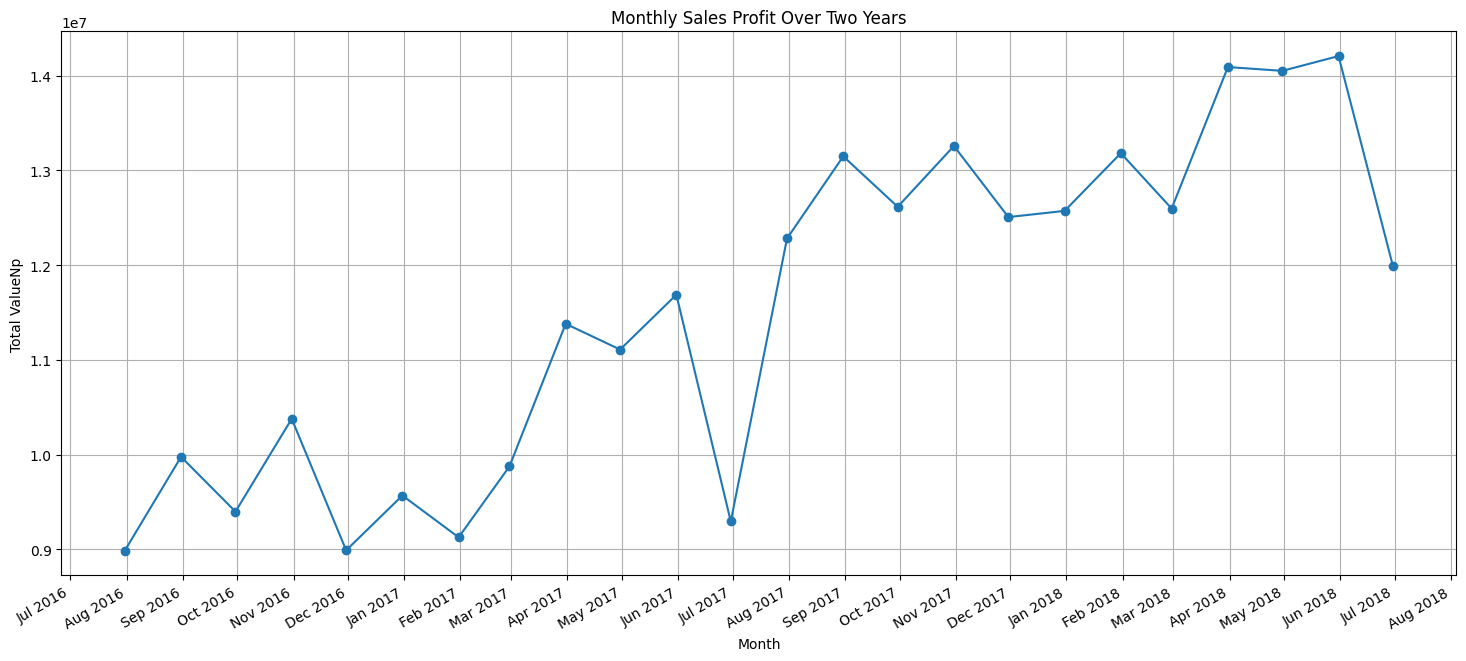

In [ ]:
import matplotlib.dates as mdates

# Group by month and calculate total ValueNp for each month
monthly_sales = df_order.resample('M', on='InvoiceDate').sum()

# Create a time series plot for monthly sales
plt.figure(figsize=(18, 8))
plt.plot(monthly_sales.index, monthly_sales['ValueNp'], marker='o', linestyle='-')
plt.title('Monthly Sales Profit Over Two Years')
plt.xlabel('Month')
plt.ylabel('Total ValueNp')
plt.grid(True)

# Format x-axis to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

plt.show()


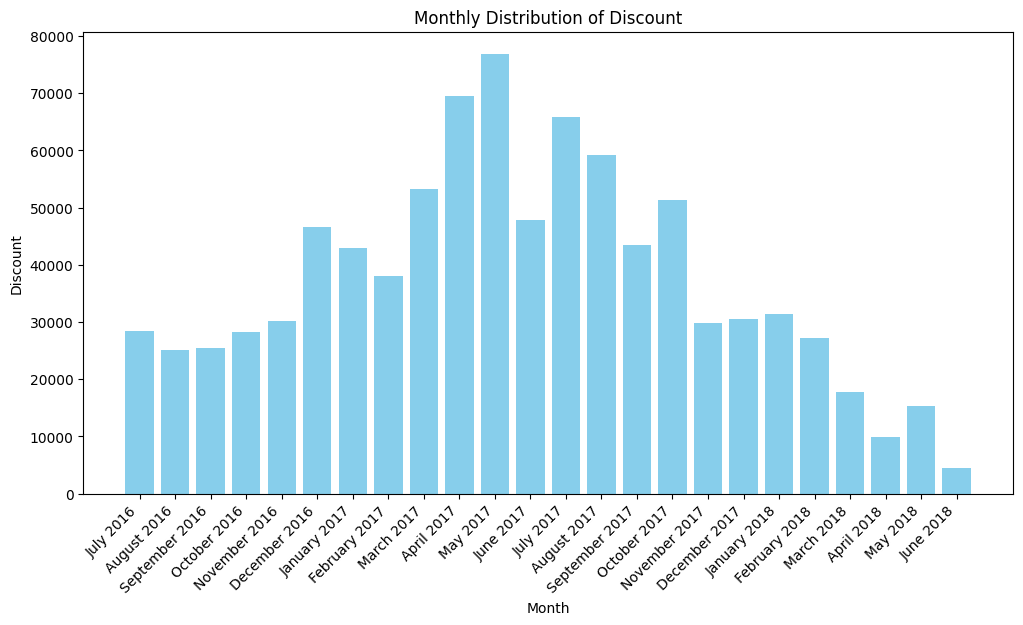

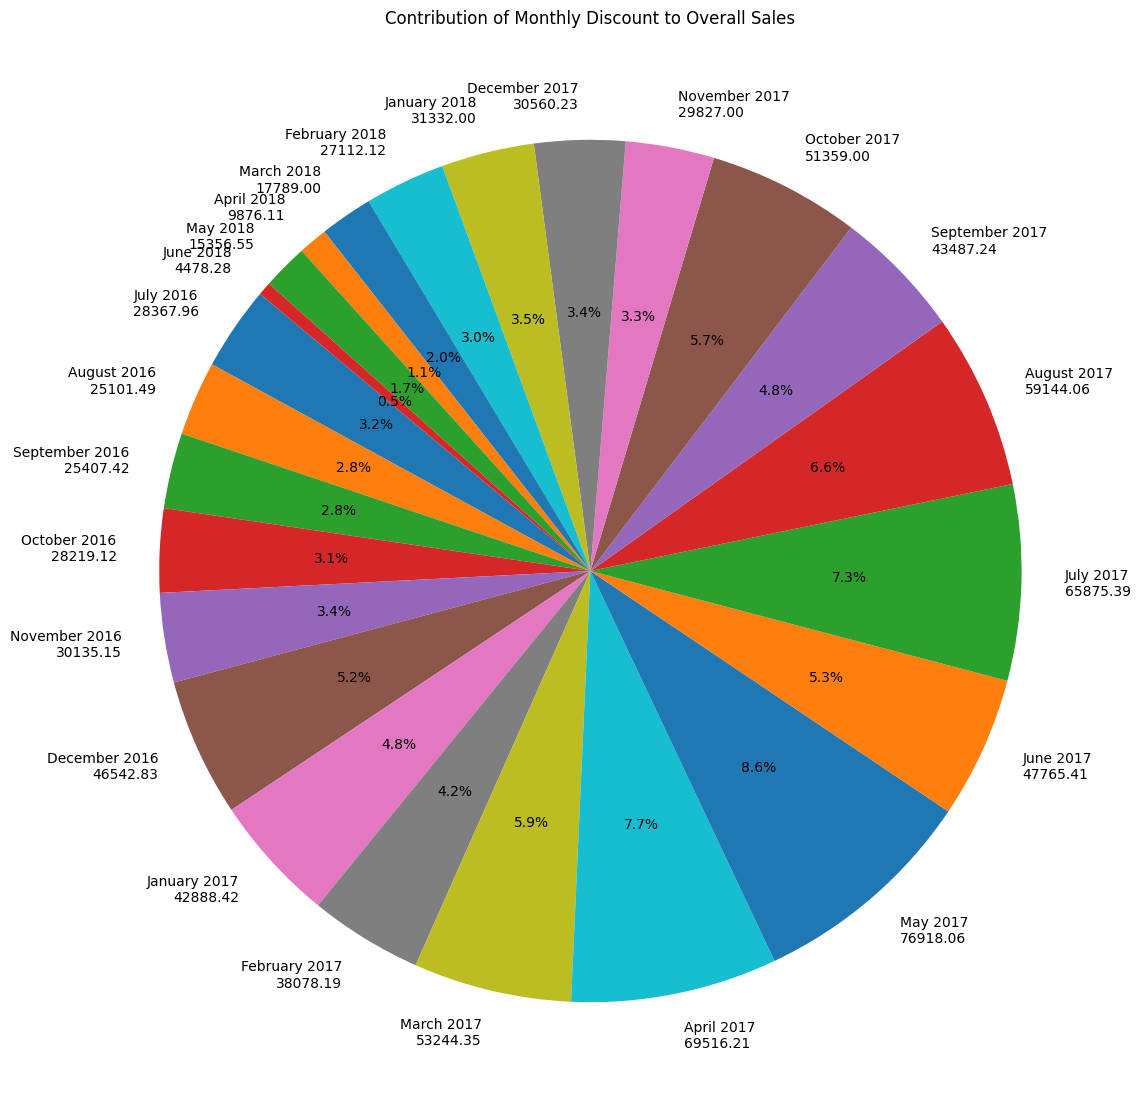

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have monthly dataframes for Discount and Units
monthly_discount = df_order.groupby(df_order['InvoiceDate'].dt.to_period("M"))['Discount'].sum()

# Plot bar chart for monthly Discount
plt.figure(figsize=(12, 6))
plt.bar(monthly_discount.index.strftime('%B %Y'), monthly_discount, color='skyblue')
plt.title('Monthly Distribution of Discount')
plt.xlabel('Month')
plt.ylabel('Discount')
plt.xticks(rotation=45, ha='right')
plt.show()


# Pie chart to show the contribution of Discount to overall sales
plt.figure(figsize=(18, 14))
labels_discount = [f"{month.strftime('%B %Y')}\n{monthly_discount[month]:.2f}" for month in monthly_discount.index]
plt.pie(monthly_discount, labels=labels_discount, autopct='%1.1f%%', startangle=140)
plt.title('Contribution of Monthly Discount to Overall Sales')
plt.show()



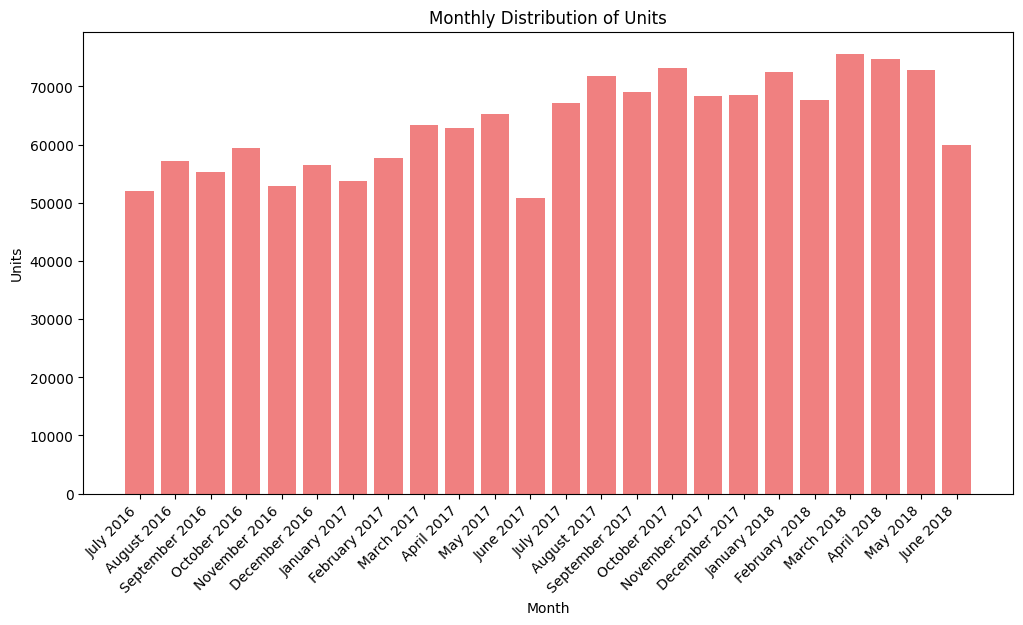

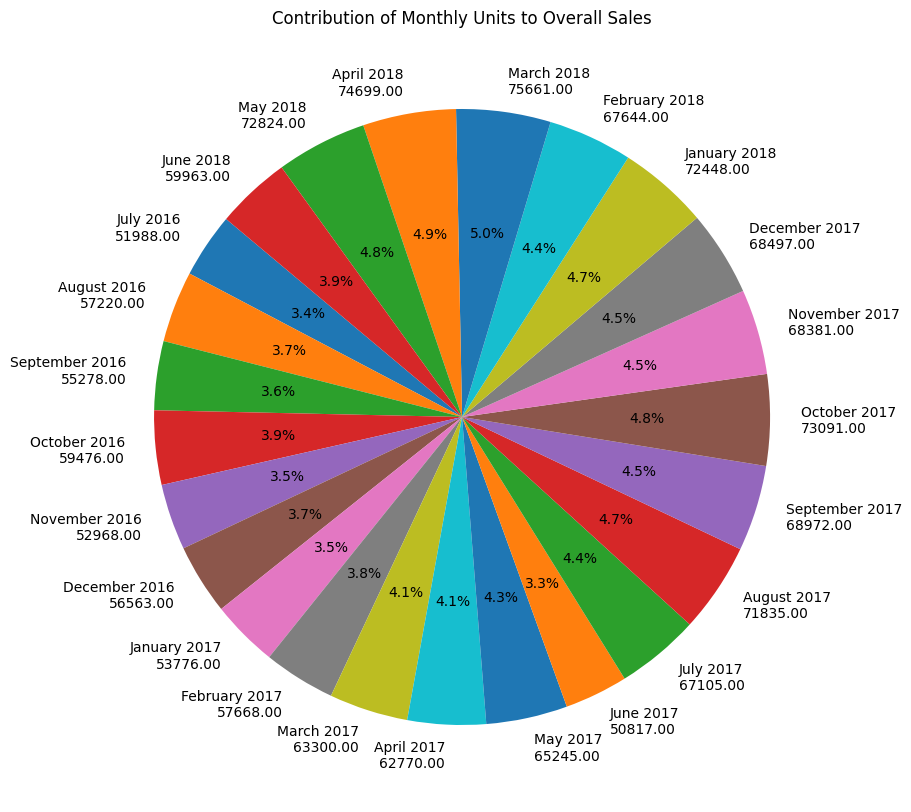

In [ ]:
monthly_units = df_order.groupby(df_order['InvoiceDate'].dt.to_period("M"))['Units'].sum()

# Plot bar chart for monthly Units
plt.figure(figsize=(12, 6))
plt.bar(monthly_units.index.strftime('%B %Y'), monthly_units, color='lightcoral')
plt.title('Monthly Distribution of Units')
plt.xlabel('Month')
plt.ylabel('Units')
plt.xticks(rotation=45, ha='right')
plt.show()

# Pie chart to show the contribution of Units to overall sales
plt.figure(figsize=(10, 10))
labels_units = [f"{month.strftime('%B %Y')}\n{monthly_units[month]:.2f}" for month in monthly_units.index]
plt.pie(monthly_units, labels=labels_units, autopct='%1.1f%%', startangle=140)
plt.title('Contribution of Monthly Units to Overall Sales')
plt.show()


# Sales over time period of 2 years

<ipython-input-55-a35129752360>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Average Sales: 11510983.751208335
Highest Sales: 14206740.54
Lowest Sales: 8986046.334


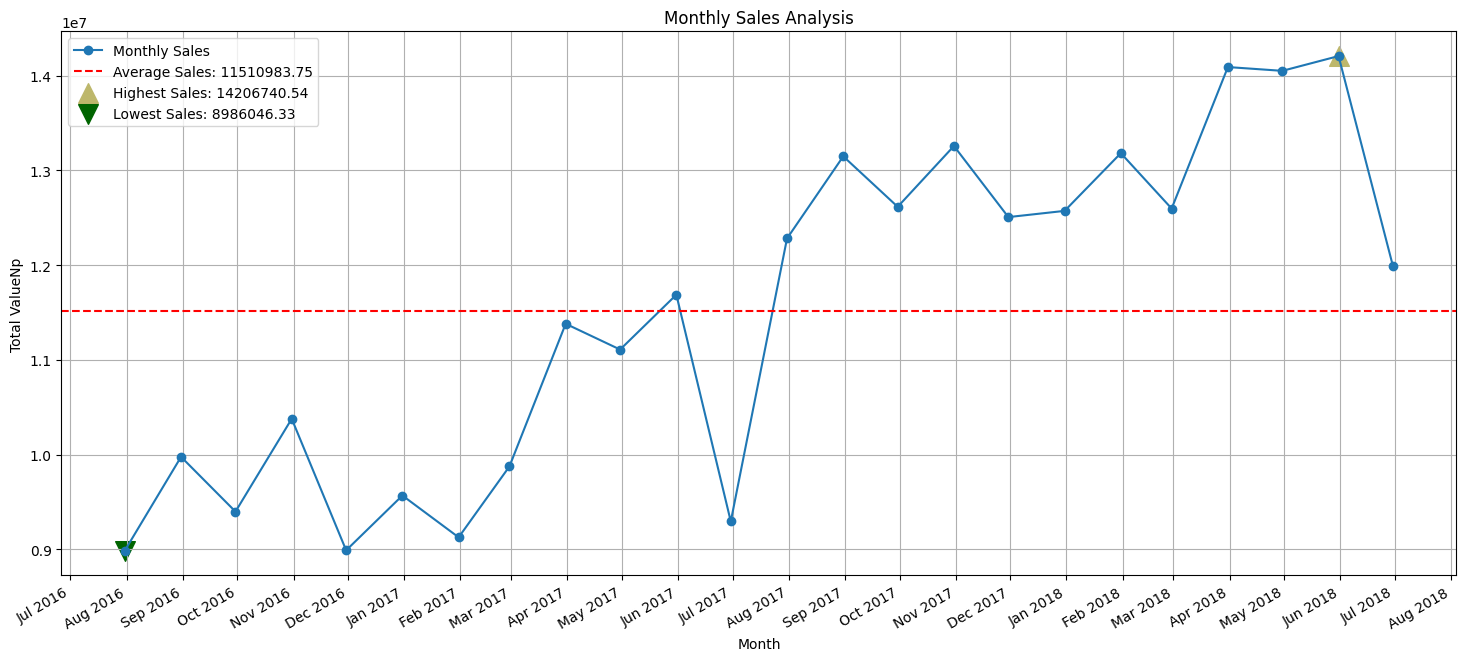

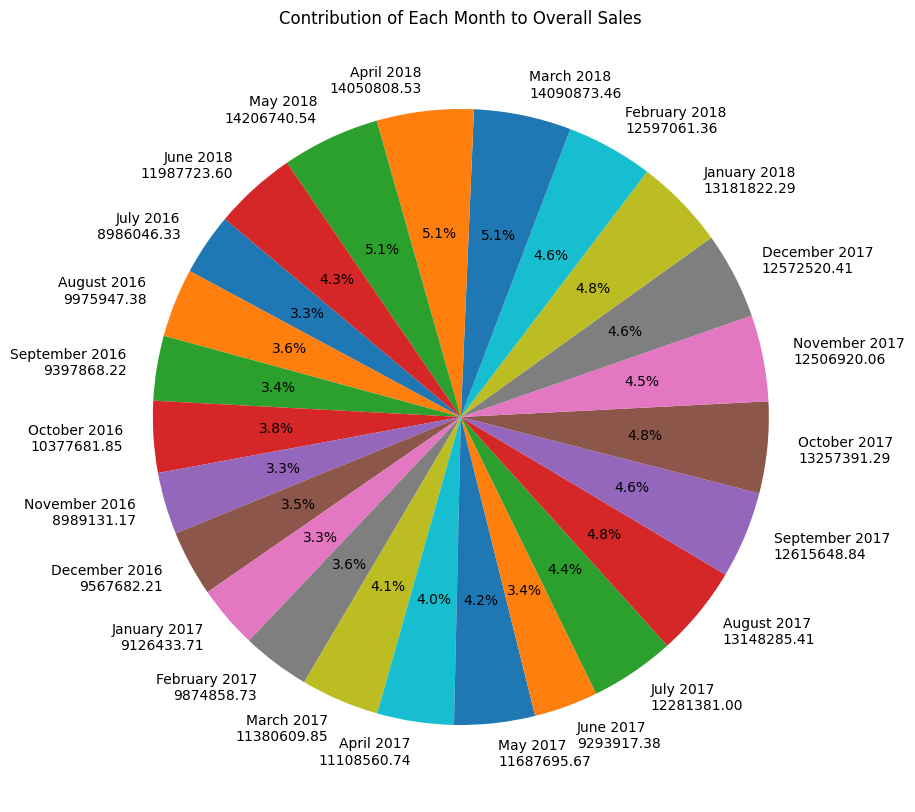

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar

# Group by month and calculate total ValueNp for each month
monthly_sales = df_order.resample('M', on='InvoiceDate').sum()

# Calculate average, highest, and lowest sales
average_sales = monthly_sales['ValueNp'].mean()
highest_sales = monthly_sales['ValueNp'].max()
lowest_sales = monthly_sales['ValueNp'].min()

print("Average Sales:", average_sales)
print("Highest Sales:", highest_sales)
print("Lowest Sales:", lowest_sales)

# Find month with highest and lowest sales
month_highest = monthly_sales['ValueNp'].idxmax().strftime('%B')
month_lowest = monthly_sales['ValueNp'].idxmin().strftime('%B')

# Plot the average, highest, and lowest sales over time
plt.figure(figsize=(18, 8))
plt.plot(monthly_sales.index, monthly_sales['ValueNp'], marker='o', linestyle='-', label='Monthly Sales')
plt.axhline(y=average_sales, color='r', linestyle='--', label=f'Average Sales: {average_sales:.2f}')
plt.scatter(monthly_sales['ValueNp'].idxmax(), highest_sales, color='darkkhaki', marker='^', s=200, label=f'Highest Sales: {highest_sales:.2f}')
plt.scatter(monthly_sales['ValueNp'].idxmin(), lowest_sales, color='darkgreen', marker='v', s=200, label=f'Lowest Sales: {lowest_sales:.2f}')

# Format x-axis to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

plt.title('Monthly Sales Analysis')
plt.xlabel('Month')
plt.ylabel('Total ValueNp')
plt.legend()
plt.grid(True)
plt.show()

# Pie chart to show the contribution of each month to overall sales
plt.figure(figsize=(10, 10))
labels = [f"{month.strftime('%B %Y')}\n{monthly_sales['ValueNp'][month]:.2f}" for month in monthly_sales.index]
plt.pie(monthly_sales['ValueNp'], labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Contribution of Each Month to Overall Sales')
plt.show()


In [ ]:
# Assuming you have monthly dataframes for Discount and Units
monthly_discount = df_order.groupby(df_order['InvoiceDate'].dt.to_period("M"))['Discount'].agg(['sum', 'max', 'min', 'mean'])
monthly_units = df_order.groupby(df_order['InvoiceDate'].dt.to_period("M"))['Units'].agg(['sum', 'max', 'min', 'mean'])

# Convert PeriodIndex to string
monthly_discount.index = monthly_discount.index.strftime('%B %Y')
monthly_units.index = monthly_units.index.strftime('%B %Y')

# Print highest, lowest, and average values for Discount
print("Discount:")
print(f"Highest Discount: {monthly_discount['max'].max():.2f} in {monthly_discount['max'].idxmax()}")
print(f"Lowest Discount: {monthly_discount['min'].min():.2f} in {monthly_discount['min'].idxmin()}")
print(f"Average Discount: {monthly_discount['mean'].mean():.2f}")

# Print highest, lowest, and average values for Units
print("\nUnits:")
print(f"Highest Units: {monthly_units['max'].max():.2f} in {monthly_units['max'].idxmax()}")
print(f"Lowest Units: {monthly_units['min'].min():.2f} in {monthly_units['min'].idxmin()}")
print(f"Average Units: {monthly_units['mean'].mean():.2f}")


Discount:
Highest Discount: 3910.00 in May 2017
Lowest Discount: -1075.27 in August 2017
Average Discount: 3.11

Units:
Highest Units: 800.00 in May 2017
Lowest Units: -125.00 in July 2017
Average Units: 5.26


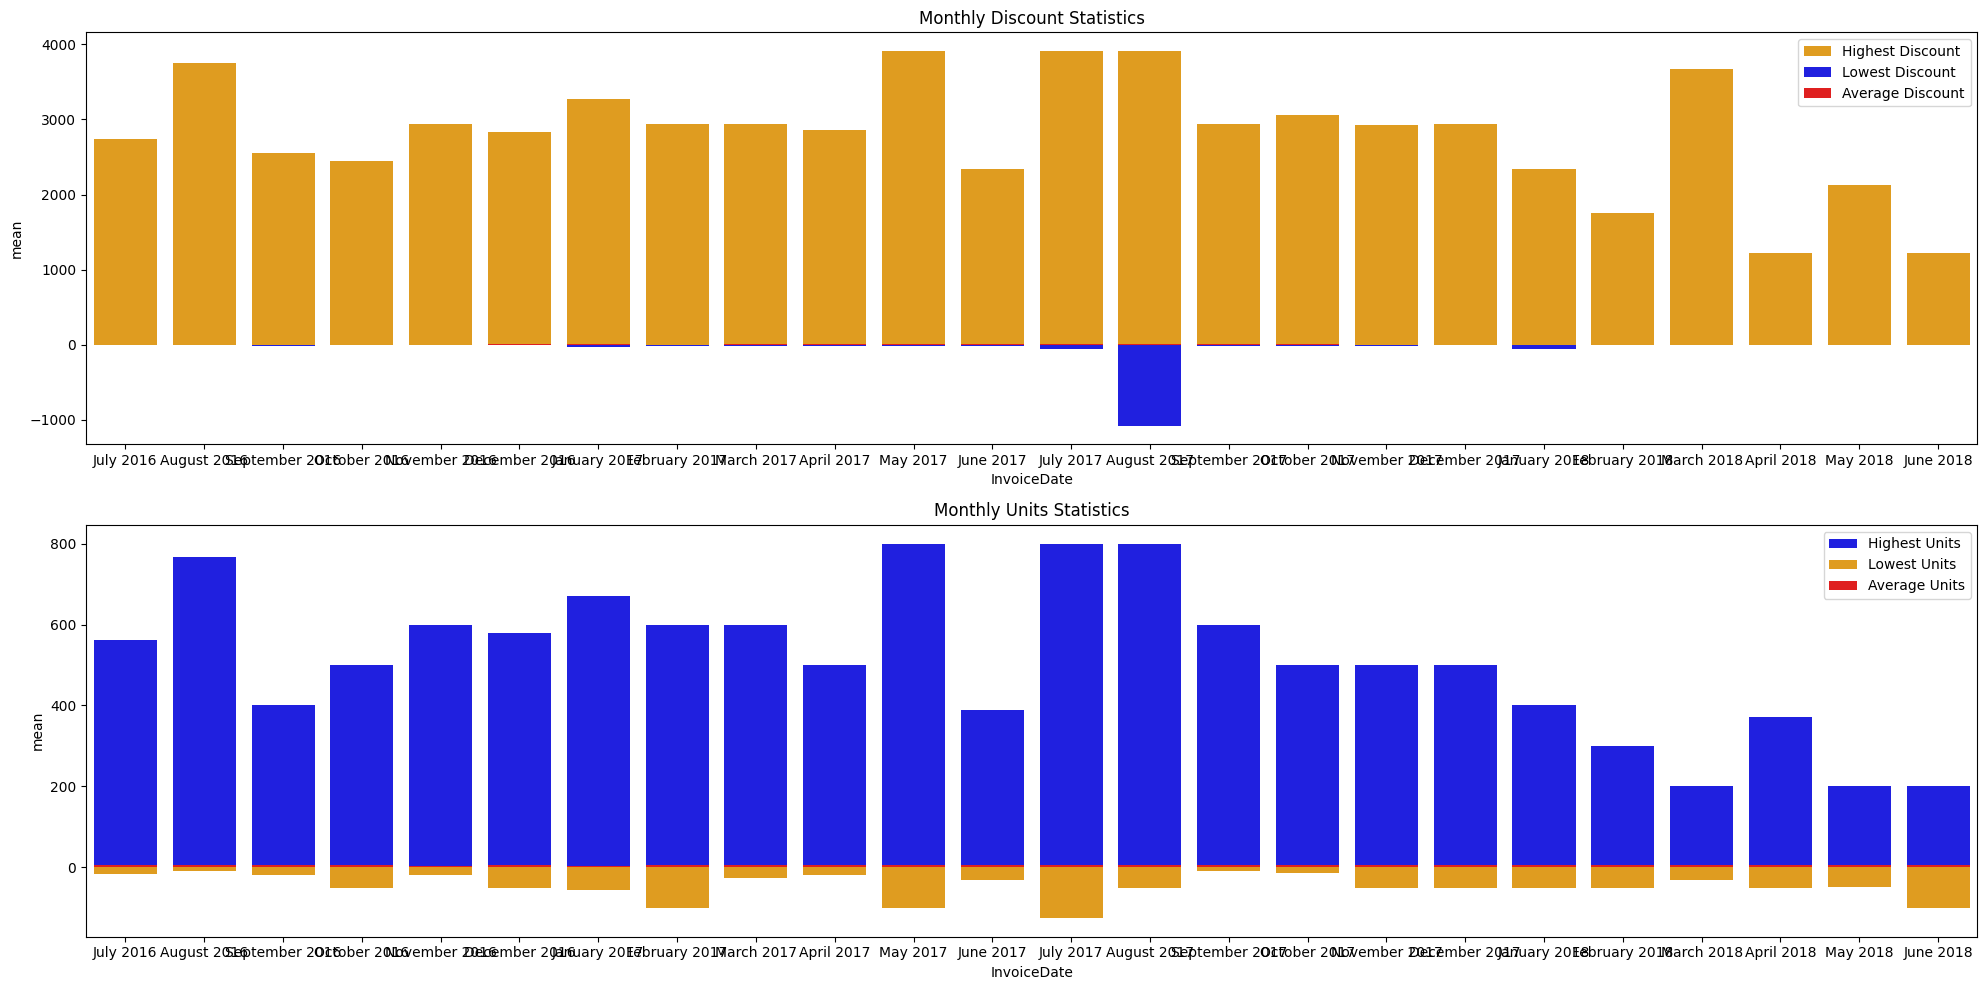

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have monthly dataframes for Discount and Units
monthly_discount = df_order.groupby(df_order['InvoiceDate'].dt.to_period("M"))['Discount'].agg(['sum', 'max', 'min', 'mean'])
monthly_units = df_order.groupby(df_order['InvoiceDate'].dt.to_period("M"))['Units'].agg(['sum', 'max', 'min', 'mean'])

# Convert PeriodIndex to string
monthly_discount.index = monthly_discount.index.strftime('%B %Y')
monthly_units.index = monthly_units.index.strftime('%B %Y')

# Create subplots for Discount
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Plot highest, lowest, and average values for Discount
sns.barplot(x=monthly_discount.index, y='max', data=monthly_discount, ax=axes[0], color='orange', label='Highest Discount')
sns.barplot(x=monthly_discount.index, y='min', data=monthly_discount, ax=axes[0], color='blue', label='Lowest Discount')
sns.barplot(x=monthly_discount.index, y='mean', data=monthly_discount, ax=axes[0], color='red', label='Average Discount')
axes[0].set_title('Monthly Discount Statistics')
axes[0].legend()

# Create subplots for Units
sns.barplot(x=monthly_units.index, y='max', data=monthly_units, ax=axes[1], color='blue', label='Highest Units')
sns.barplot(x=monthly_units.index, y='min', data=monthly_units, ax=axes[1], color='orange', label='Lowest Units')
sns.barplot(x=monthly_units.index, y='mean', data=monthly_units, ax=axes[1], color='red', label='Average Units')
axes[1].set_title('Monthly Units Statistics')
axes[1].legend()

plt.tight_layout()
plt.show()


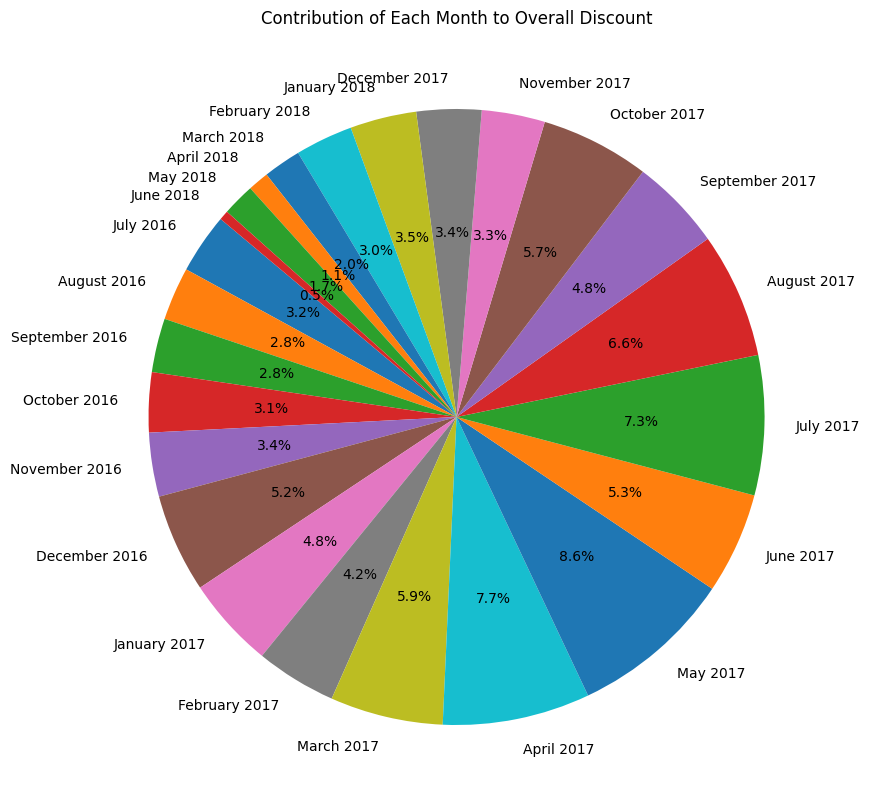

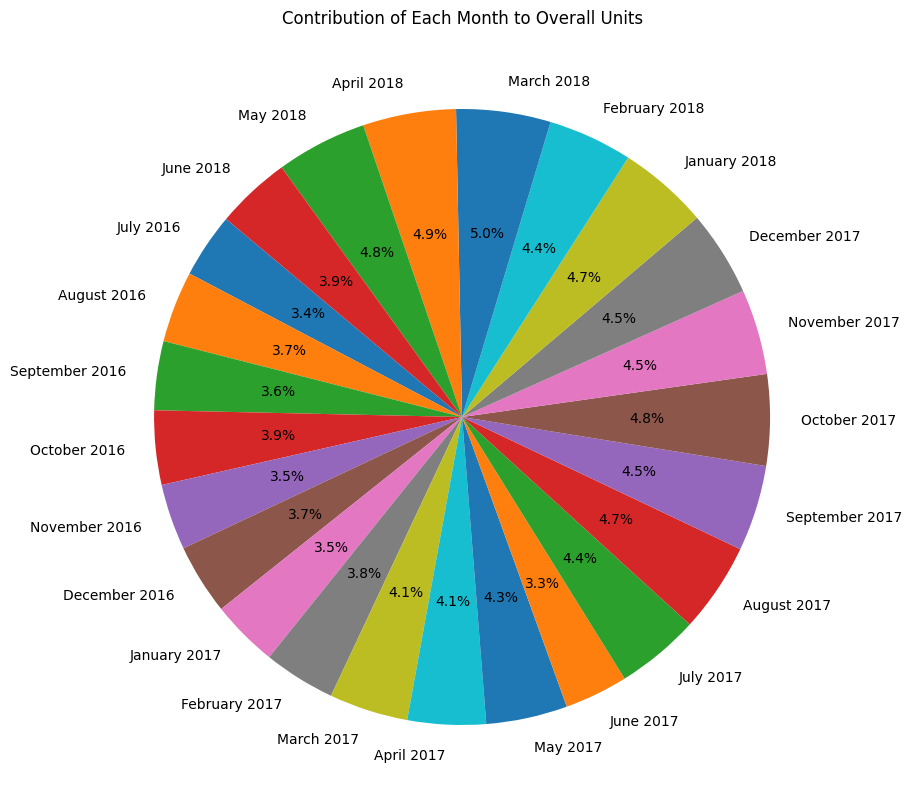

In [ ]:
# Pie chart to show the contribution of each month to overall Discount
plt.figure(figsize=(10, 10))
plt.pie(monthly_discount['sum'], labels=monthly_discount.index, autopct='%1.1f%%', startangle=140)
plt.title('Contribution of Each Month to Overall Discount')
plt.show()

# Pie chart to show the contribution of each month to overall Units
plt.figure(figsize=(10, 10))
plt.pie(monthly_units['sum'], labels=monthly_units.index, autopct='%1.1f%%', startangle=140)
plt.title('Contribution of Each Month to Overall Units')
plt.show()

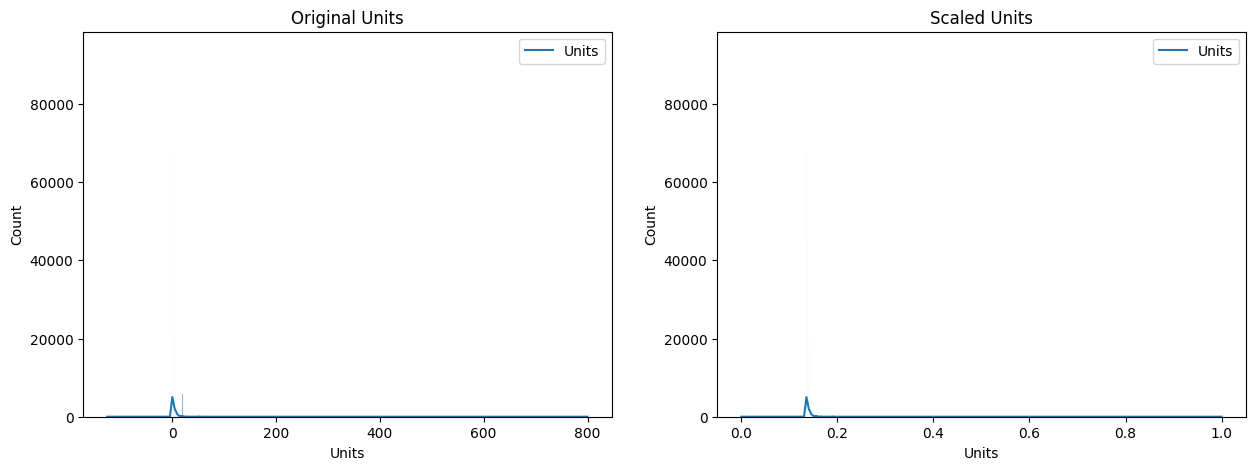

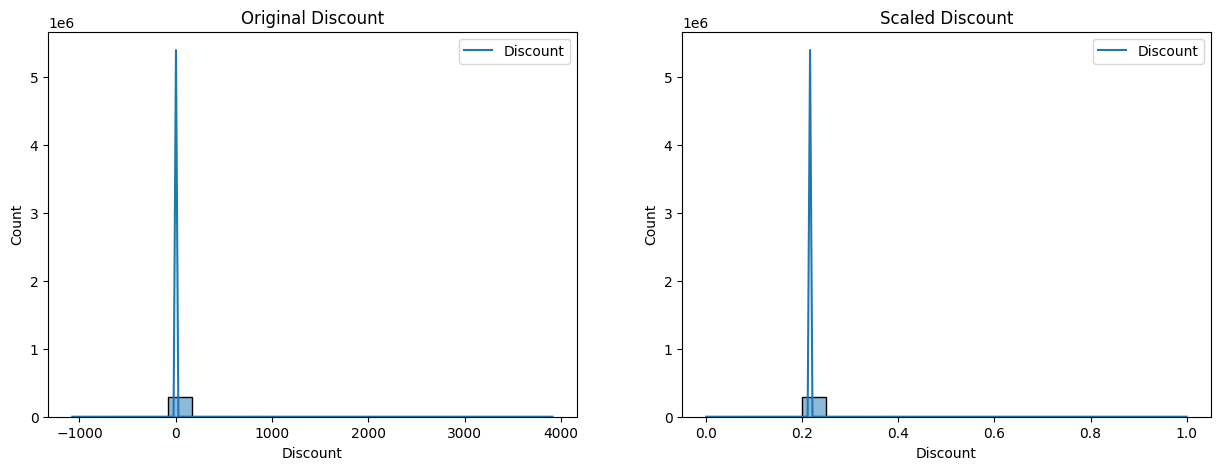

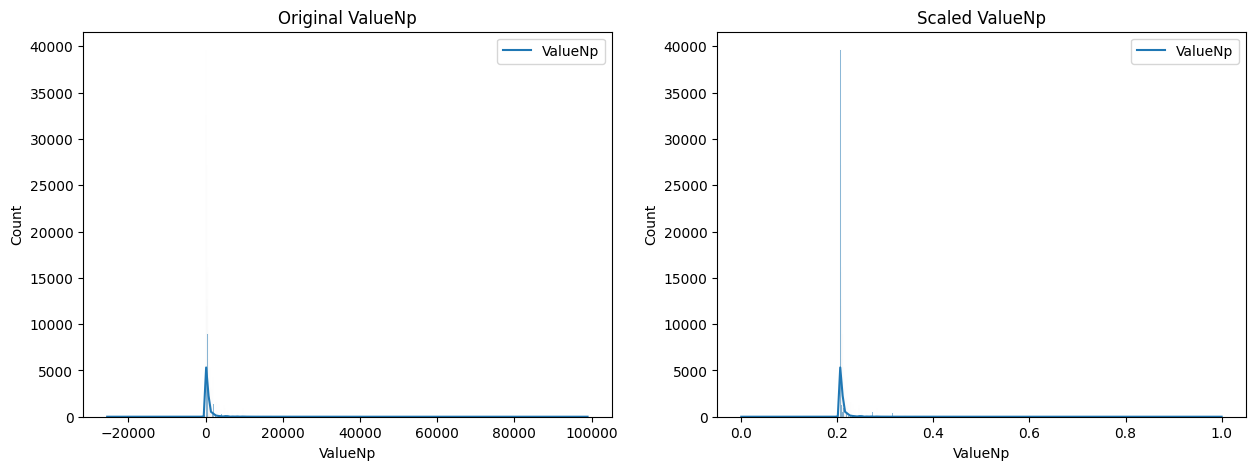

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# Select columns to scale
columns_to_scale = ['Units', 'Discount', 'ValueNp']

# Create a separate plot for each column
for column in columns_to_scale:
    # Apply Min-Max scaling
    scaled_data = df_order.copy()
    scaled_data[column] = minmax_scale(df_order[column])

    # Plot original and scaled data
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Original Data
    sns.histplot(df_order[column], kde=True, ax=ax[0])
    ax[0].set_title(f"Original {column}")
    ax[0].legend([column])

    # Scaled Data
    sns.histplot(scaled_data[column], kde=True, ax=ax[1])
    ax[1].set_title(f"Scaled {column}")
    ax[1].legend([column])

    plt.show()


               Units      Discount        ValueNp
count  290514.000000  290514.00000  290514.000000
mean        0.140822       0.21631       0.212560
std         0.014942       0.01223       0.019230
min         0.000000       0.00000       0.000000
25%         0.136216       0.21569       0.206489
50%         0.137297       0.21569       0.207746
75%         0.140541       0.21569       0.211516
max         1.000000       1.00000       1.000000


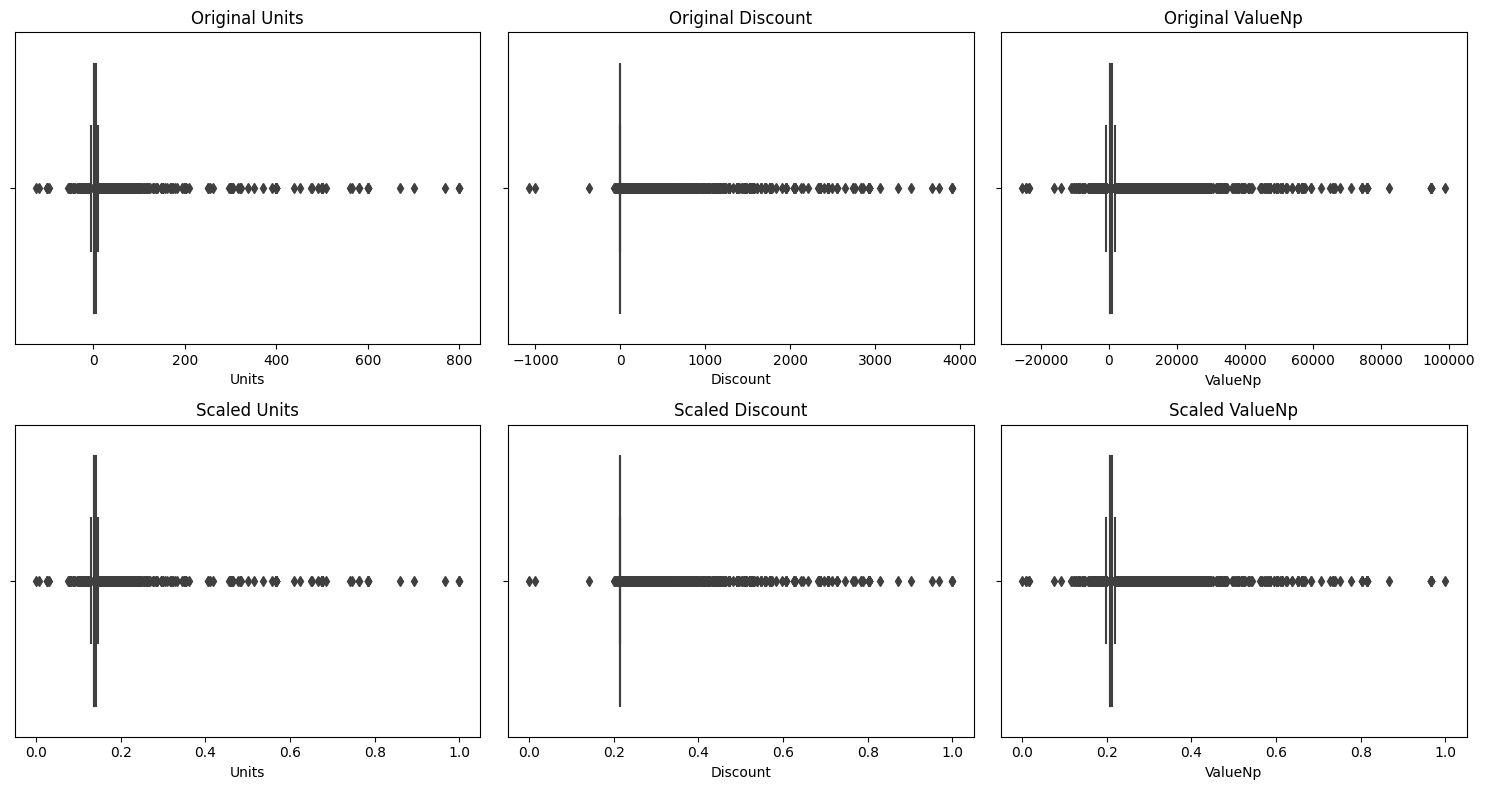

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# Select columns to scale
columns_to_scale = ['Units', 'Discount', 'ValueNp']

# Apply Min-Max scaling
scaled_data = df_order.copy()
scaled_data[columns_to_scale] = minmax_scale(df_order[columns_to_scale])

# Create subplots
fig, axes = plt.subplots(2, len(columns_to_scale), figsize=(15, 8))

# Display descriptive statistics of scaled data
print(scaled_data[columns_to_scale].describe())

# Visualize box plots for each numerical column
for i, column in enumerate(columns_to_scale):
    # Original Box Plot
    sns.boxplot(x=df_order[column], ax=axes[0, i])
    axes[0, i].set_title(f'Original {column}')

    # Scaled Box Plot
    sns.boxplot(x=scaled_data[column], ax=axes[1, i])
    axes[1, i].set_title(f'Scaled {column}')

# Adjust layout
plt.tight_layout()
plt.show()


## value counts of each feature

In [ ]:
# df_order["DistributorCode"].value_counts()
# df_order["DistributorName"].value_counts()
# df_order["ClientCode"].value_counts()
# df_order["ClientName"].value_counts()
# df_order["BrickName"].value_counts()
# df_order["Product"].value_counts()
# df_order["SKU"].value_counts()
# df_order["ValueNp"].value_counts()
# df_order["Discount"].value_counts()
# df_order["Units"].value_counts()
df_order["InvoiceDate"].value_counts()

2017-02-16    774
2017-04-30    753
2017-08-17    684
2018-02-08    683
2017-10-11    679
             ... 
2016-09-16     57
2016-07-01     44
2018-06-18     43
2016-12-12     39
2017-05-01      9
Name: InvoiceDate, Length: 666, dtype: int64

In [ ]:
# Select columns to scale
columns_to_scale = ['Units', 'Discount', 'ValueNp']

# Apply Min-Max scaling
scaled_data = df_order.copy()
scaled_data[columns_to_scale] = minmax_scale(df_order[columns_to_scale])


## converting categorical features to numerical

In [ ]:
dist_name = {
    "Premier Agencies - HYDERABAD": 1,
    "Premier Agencies - Peshawar": 2,
    "Premier Agencies - Sukkur": 3,
}

df_order["DistributorName"] = df_order["DistributorName"].replace(dist_name)

In [ ]:
dist_code = {
    2715: 1,
    3996: 2,
    2718: 3
}

df_order["DistributorCode"] = df_order["DistributorCode"].replace(dist_code)


In [ ]:
prod = {
    "Prod-NS": 1,
    "Prod-XP": 2,
    "Prod-IPL": 3,
    "Prod-EF": 4,
    "Prod-AC": 5
}

df_order["Product_encoded"] = df_order["Product"].replace(prod)


In [ ]:
sku_map = {
    "Prod-NS-Tab": 1.1,
    "Prod-XP-05": 2.1,
    "Prod-XP-10": 2.2,
    "Prod-XP-20": 2.3,
    "Prod-IPL-500 10's": 3.1,
    "Prod-IPL-500 14's": 3.2,
    "Prod-IPL-850 10's": 3.3,
    "Prod-IPL-1000 10's": 3.4,
    "Prod-IPL-1000 14's": 3.5,
    "Prod-EF-30": 4.1,
    "Prod-EF-60": 4.2,
    "Prod-EF-Cap": 4.3,
    "Prod-EF-DS": 4.3,
    "Prod-AC-Tab": 5.1
}

df_order["SKU_encoded"] = df_order["SKU"].replace(sku_map)

In [ ]:

le = LabelEncoder()
df_order["ClientName_encoded"] = le.fit_transform(df_order["ClientName"])


In [ ]:
# le = LabelEncoder()
# df_order["ClientCode_encoded"] = le.fit_transform(df_order["ClientCode"])

In [ ]:
le = LabelEncoder()
df_order["BrickName_encoded"] = le.fit_transform(df_order["BrickName"])

In [ ]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290514 entries, 0 to 290513
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DistributorCode     290514 non-null  int64  
 1   DistributorName     290514 non-null  object 
 2   ClientCode          290514 non-null  int64  
 3   ClientName          290514 non-null  object 
 4   BrickName           290514 non-null  object 
 5   Product             290514 non-null  object 
 6   SKU                 290514 non-null  object 
 7   InvoiceDate         290514 non-null  object 
 8   Units               290514 non-null  int64  
 9   Bonus               290514 non-null  int64  
 10  Discount            290514 non-null  float64
 11  ValueNp             290514 non-null  float64
 12  Product_encoded     290514 non-null  int64  
 13  SKU_encoded         290514 non-null  float64
 14  ClientName_encoded  290514 non-null  int64  
 15  BrickName_encoded   290514 non-nul

## dropping categorical columns

In [ ]:

drop = ['DistributorName','ClientCode', 'ClientName', 'BrickName', 'Product', 'SKU', 'Bonus']
df_order = df_order.drop(columns=drop, inplace=False)


In [ ]:

drop = ['InvoiceDate', 'ValueNp', 'Discount', 'Units']
df_order = df_order.drop(columns=drop, inplace=False)

df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290514 entries, 0 to 290513
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DistributorCode     290514 non-null  int64  
 1   Product_encoded     290514 non-null  int64  
 2   SKU_encoded         290514 non-null  float64
 3   ClientName_encoded  290514 non-null  int64  
 4   BrickName_encoded   290514 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 11.1 MB


# Shap

RandomForestRegressor(n_estimators=300, random_state=42)

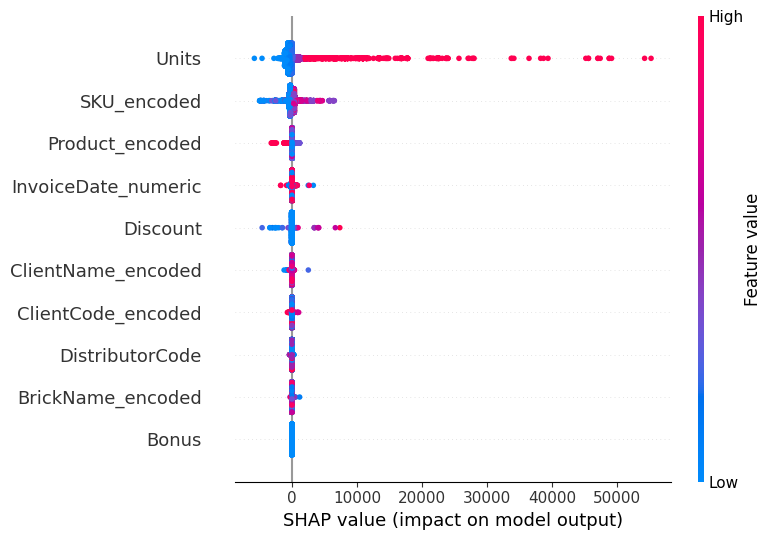

In [ ]:

# Initialize a Spark session
spark = SparkSession.builder.appName("SHAPExample").getOrCreate()


subset_size = 5000
df_subset = df_order.head(subset_size)

# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df_subset)

# Drop InvoiceDate for the features
X_subset = spark_df.drop('InvoiceDate')

# Select both features and target variable
df_for_model = spark_df.select(['DistributorCode', 'Units', 'Discount', 'Product_encoded', 'SKU_encoded', 'ClientName_encoded', 'BrickName_encoded', 'ValueNp'])

# Split the data into training and testing sets
train_df, test_df = df_for_model.randomSplit([0.8, 0.2], seed=42)

# Train a model (Random Forest Regressor)
feature_cols = [col for col in df_for_model.columns if col not in ['ValueNp']]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
rf_model = RandomForestRegressor(numTrees=3000, seed=42, labelCol='ValueNp')
pipeline = Pipeline(stages=[vector_assembler, rf_model])
model = pipeline.fit(train_df)

# Make predictions on the test set
predictions = model.transform(test_df)
y_test = predictions.select('ValueNp').toPandas()['ValueNp']
y_pred = predictions.select('prediction').toPandas()['prediction']

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



## Model Accuracy

In [ ]:

# Assuming df is your DataFrame with the specified columns
subset_size = 40000
df_subset = df_order.head(subset_size)

# Drop InvoiceDate and ValueNp for the features
X_subset = df_subset.drop(['InvoiceDate', 'ValueNp'], axis=1)
y_subset = df_subset['ValueNp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Train a model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



RandomForestRegressor(n_estimators=500, random_state=42)

Mean Absolute Error: 26.747065945744595
Mean Squared Error: 110463.5944712081
R-squared: 0.9800671781422261


## Dataset size increased

In [ ]:

subset_size = 140000
df_subset = df_order.head(subset_size)

# Drop InvoiceDate and ValueNp for the features
X_subset = df_subset.drop(['InvoiceDate', 'ValueNp'], axis=1)
y_subset = df_subset['ValueNp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Train a model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=3000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot for global interpretation
shap.summary_plot(shap_values, X_test, show=False)
plt.title('Summary Plot for Global Interpretation')
plt.show()

# Dependence plot for a specific feature
feature_name = 'DistributorCode'
shap.dependence_plot(feature_name, shap_values, X_test, show=False)
plt.title(f'Dependence Plot for {feature_name}')
plt.show()


RandomForestRegressor(n_estimators=3000, random_state=42)

Mean Absolute Error: 19.248286645979547


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 26.747065945744595
Mean Squared Error: 110463.5944712081
R-squared: 0.9800671781422261


In [ ]:

# Initialize a Spark session
spark = SparkSession.builder.appName("SHAPExample").getOrCreate()

# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df_order)

# Drop InvoiceDate for the features
X_subset = spark_df.drop('InvoiceDate')

# Select both features and target variable
df_for_model = spark_df.select(['DistributorCode', 'Units', 'Discount', 'Product_encoded', 'SKU_encoded', 'ClientName_encoded', 'BrickName_encoded', 'ValueNp'])

# Split the data into training and testing sets
train_df, test_df = df_for_model.randomSplit([0.8, 0.2], seed=42)

# Train a model (Random Forest Regressor)
feature_cols = [col for col in df_for_model.columns if col not in ['ValueNp']]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
rf_model = RandomForestRegressor(numTrees=3000, seed=42, labelCol='ValueNp')
pipeline = Pipeline(stages=[vector_assembler, rf_model])
model = pipeline.fit(train_df)

# Make predictions on the test set
predictions = model.transform(test_df)
y_test = predictions.select('ValueNp').toPandas()['ValueNp']
y_pred = predictions.select('prediction').toPandas()['prediction']

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 305.04101411974335
Mean Squared Error: 945727.7917357596
R-squared: 0.8427643018121261


check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning


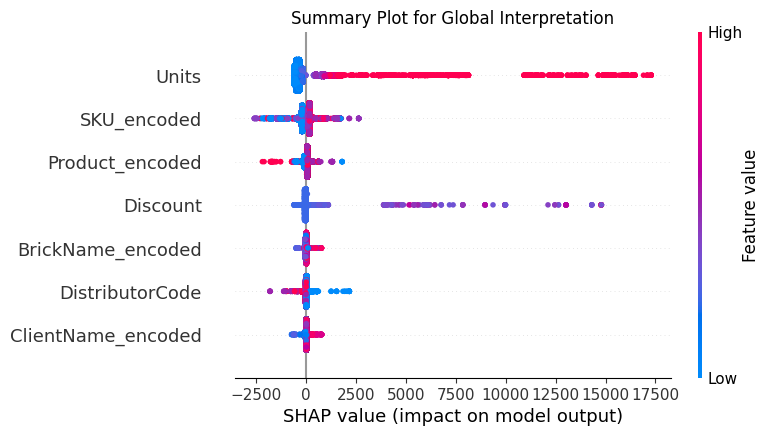

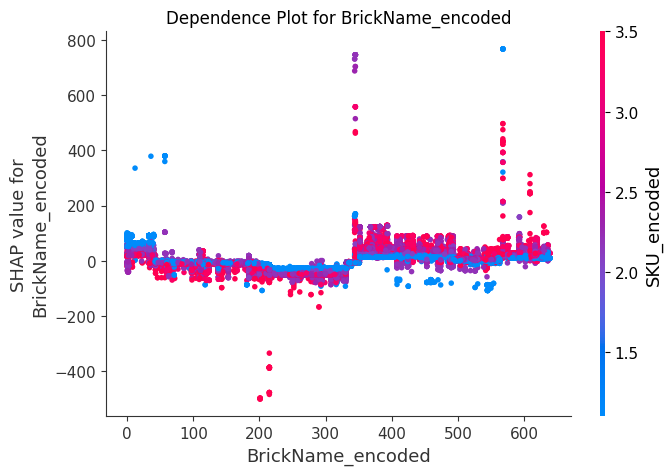

In [ ]:

explainer = shap.TreeExplainer(model.stages[-1])

X_test_pd = test_df.toPandas().drop('ValueNp', axis=1)

shap_values = explainer.shap_values(X_test_pd)

shap.summary_plot(shap_values, X_test_pd, show=False)
plt.title('Summary Plot for Global Interpretation')
plt.show()

feature_name = 'BrickName_encoded'
shap.dependence_plot(feature_name, shap_values, X_test_pd, show=False)
plt.title(f'Dependence Plot for {feature_name}')
plt.show()

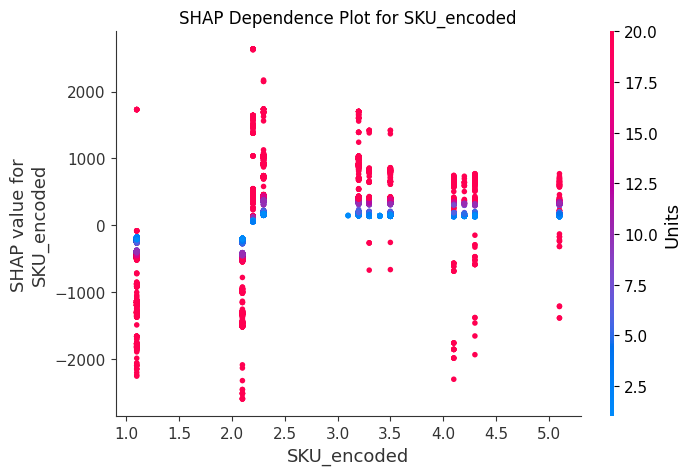

In [ ]:
# SHAP Dependence Plot for a specific feature
feature_name = 'SKU_encoded'
shap.dependence_plot(feature_name, shap_values, X_test_pd, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name}')
plt.show()



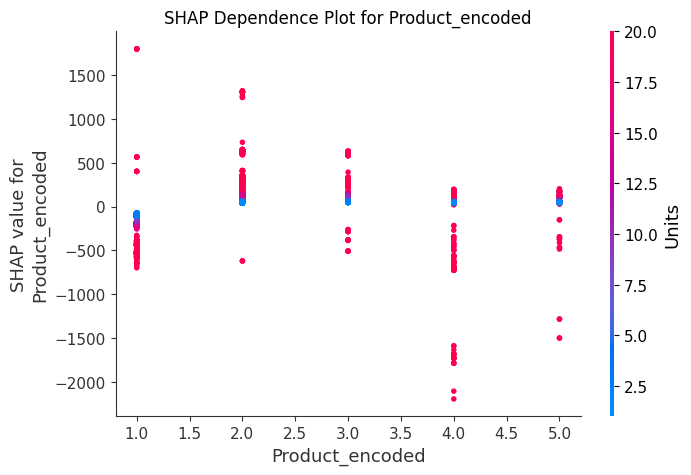

In [ ]:
# SHAP Dependence Plot for a specific feature
feature_name = 'Product_encoded'
shap.dependence_plot(feature_name, shap_values, X_test_pd, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name}')
plt.show()



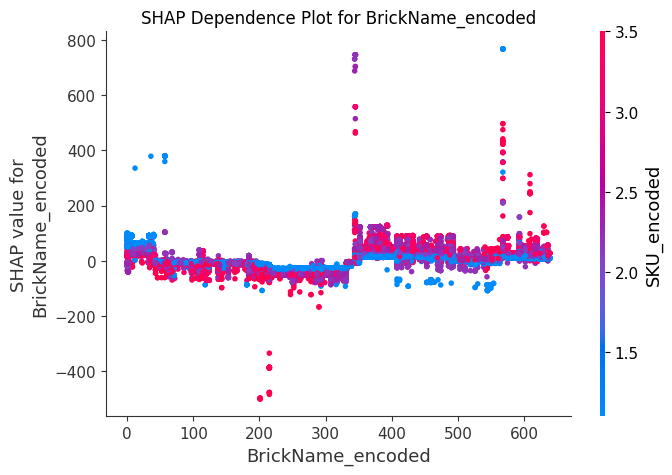

In [ ]:
# SHAP Dependence Plot for a specific feature
feature_name = 'BrickName_encoded'
shap.dependence_plot(feature_name, shap_values, X_test_pd, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name}')
plt.show()



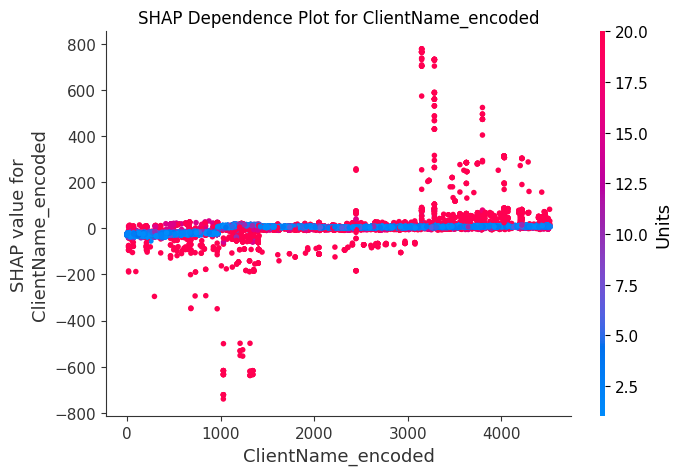

In [ ]:
# SHAP Dependence Plot for a specific feature
feature_name = 'ClientName_encoded'
shap.dependence_plot(feature_name, shap_values, X_test_pd, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name}')
plt.show()

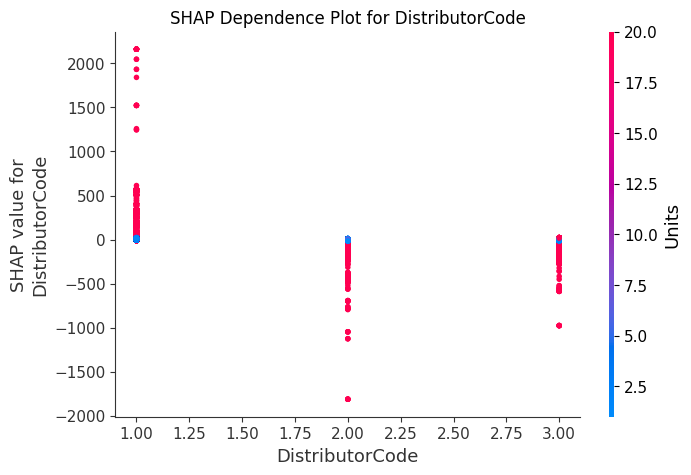

In [ ]:
# SHAP Dependence Plot for a specific feature
feature_name = 'DistributorCode'
shap.dependence_plot(feature_name, shap_values, X_test_pd, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name}')
plt.show()

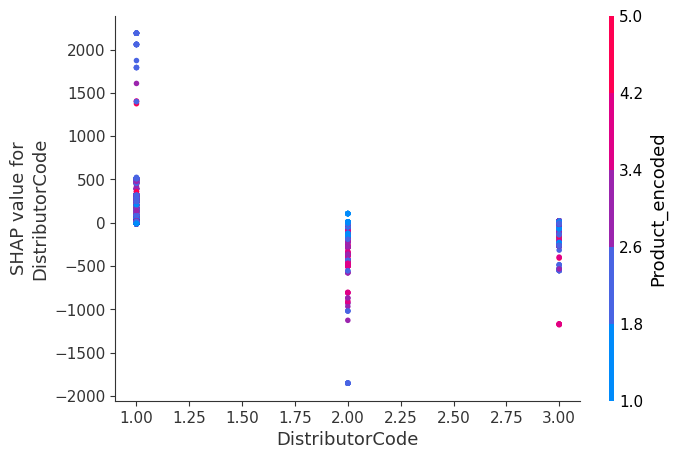

In [ ]:
shap.dependence_plot("DistributorCode", shap_values, X_test_pd,interaction_index="Product_encoded")

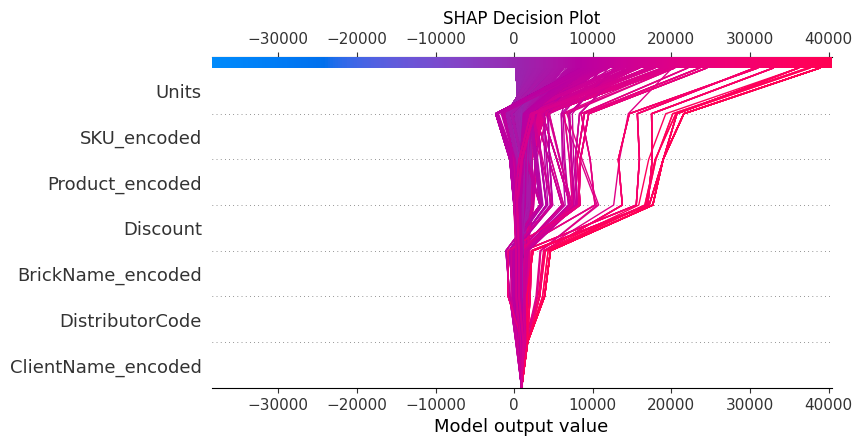

In [ ]:
# SHAP Decision Plot
shap.decision_plot(explainer.expected_value, shap_values, X_test_pd, feature_order='importance', link='identity', show=False, ignore_warnings=True)
plt.title('SHAP Decision Plot')
plt.show()


## SHAP Analysis for features

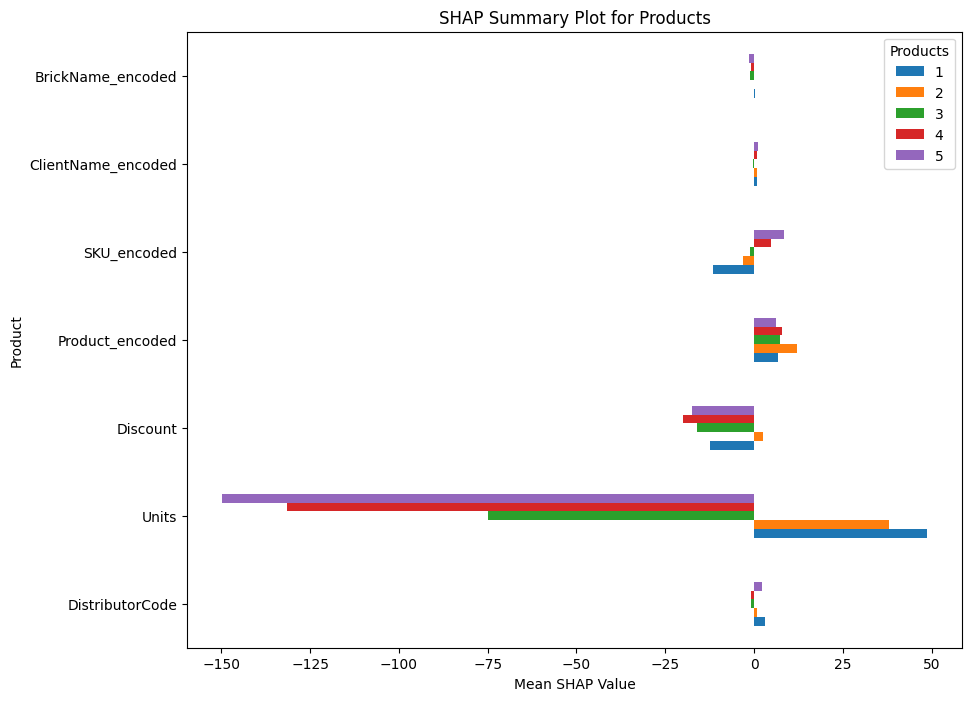

In [ ]:
# Create a DataFrame for SHAP values with product names
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["Products"] = df_order["Product_encoded"]

# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("Products").mean()

# Plot the SHAP summary for each product
shap_summary.T.plot(kind='barh', figsize=(10, 8))
plt.title('SHAP Summary Plot for Products')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Product')
plt.show()


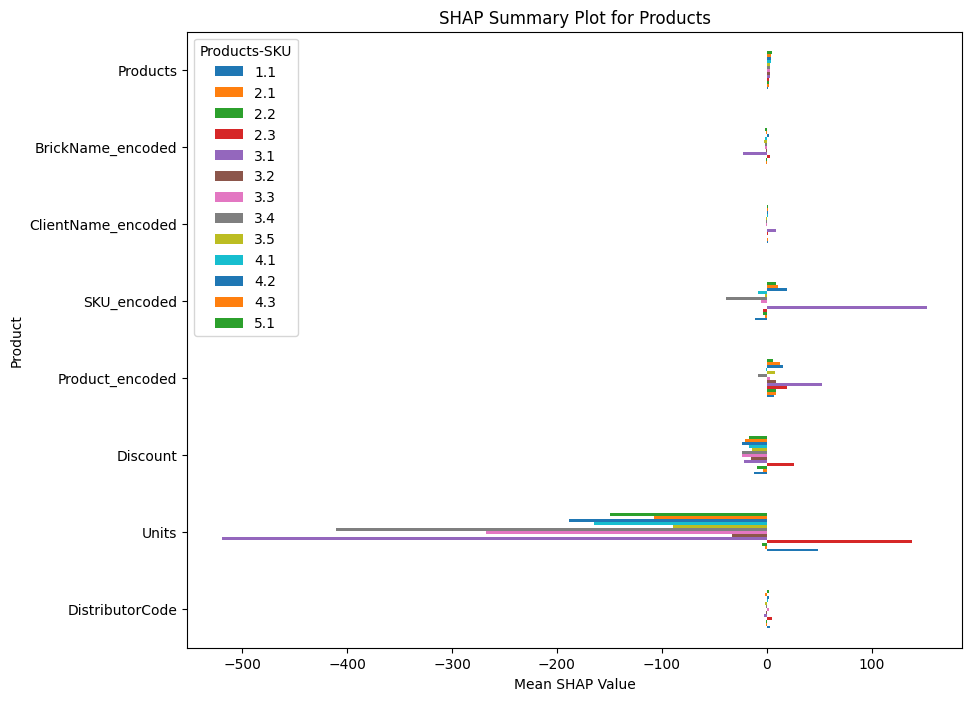

In [ ]:
# Create a DataFrame for SHAP values with product names
# shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["Products-SKU"] = df_order["SKU_encoded"]

# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("Products-SKU").mean()

# Plot the SHAP summary for each product
shap_summary.T.plot(kind='barh', figsize=(10, 8))
plt.title('SHAP Summary Plot for Products')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Product')
plt.show()


In [ ]:
import plotly.express as px

shap_summary = shap_df.groupby("Products").mean()

# Create an interactive bar plot using Plotly
fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for Products',
             labels={'value': 'Mean SHAP Value', 'Products': 'Product'})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

shap_summary = shap_df.groupby("Products-SKU").mean()

# Create an interactive bar plot using Plotly
fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for Products',
             labels={'value': 'Mean SHAP Value', 'Products': 'Product'})

# Show the plot
fig.show()


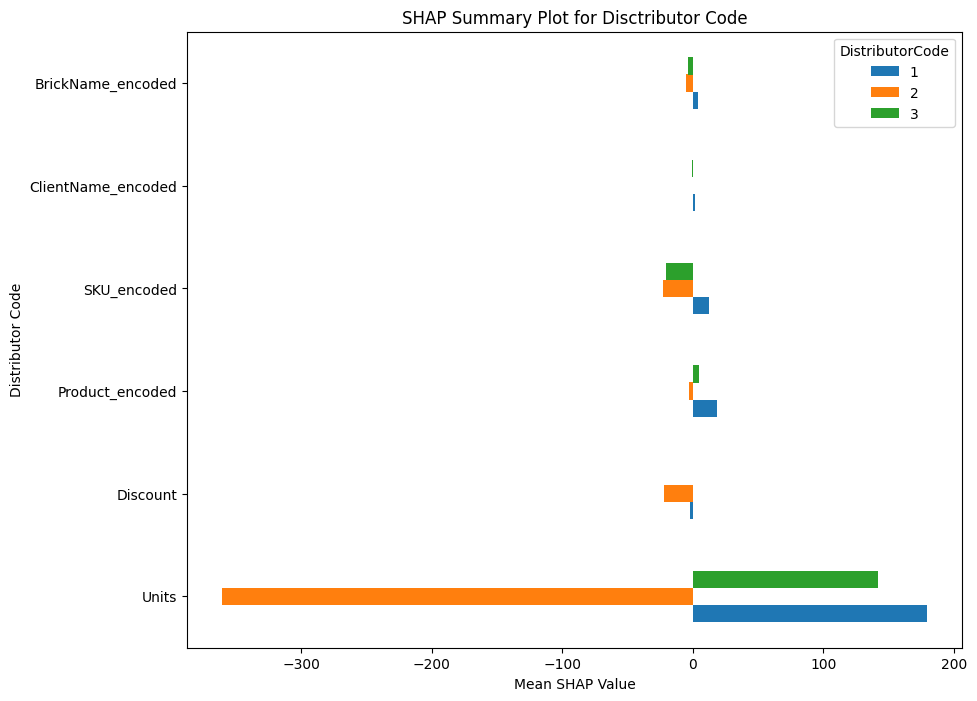

In [ ]:
# Create a DataFrame for SHAP values with product names
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["DistributorCode"] = df_order["DistributorCode"]

# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("DistributorCode").mean()

# Plot the SHAP summary for each product
shap_summary.T.plot(kind='barh', figsize=(10, 8))
plt.title('SHAP Summary Plot for Disctributor Code')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Distributor Code')
plt.show()

fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for Distributors',
             labels={'value': 'Mean SHAP Value', 'Distributors': 'Distributor'})

# Show the plot
fig.show()



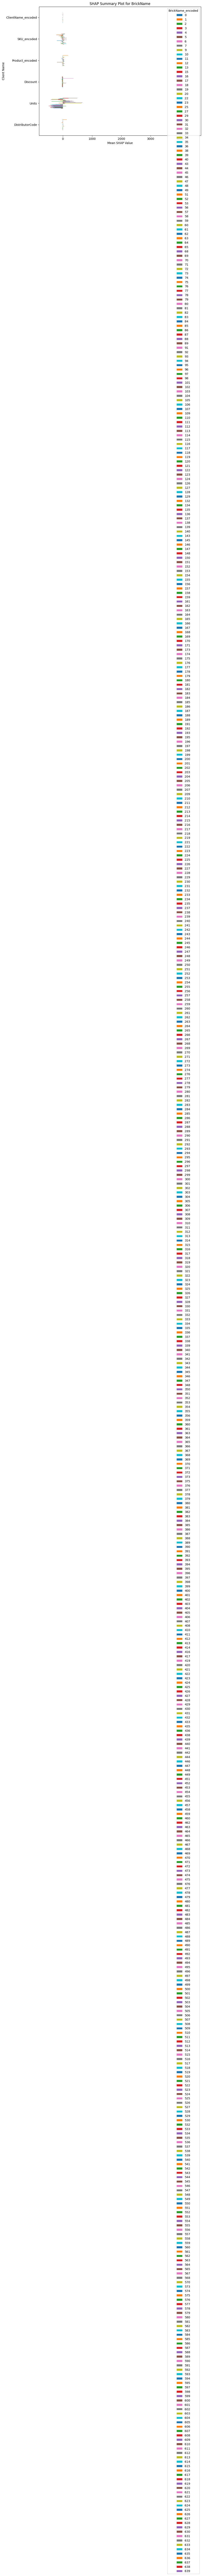

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [ ]:
# Create a DataFrame for SHAP values with product names
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["BrickName_encoded"] = df_order["BrickName_encoded"]

# BrickName_encoded


# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("BrickName_encoded").mean()

# Plot the SHAP summary for each product
shap_summary.T.plot(kind='barh', figsize=(10, 8))
plt.title('SHAP Summary Plot for BrickName')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Client Name')
plt.show()

fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for BrickName ',
             labels={'value': 'Mean SHAP Value', 'BrickName': 'BrickName'})

# Show the plot
fig.show()



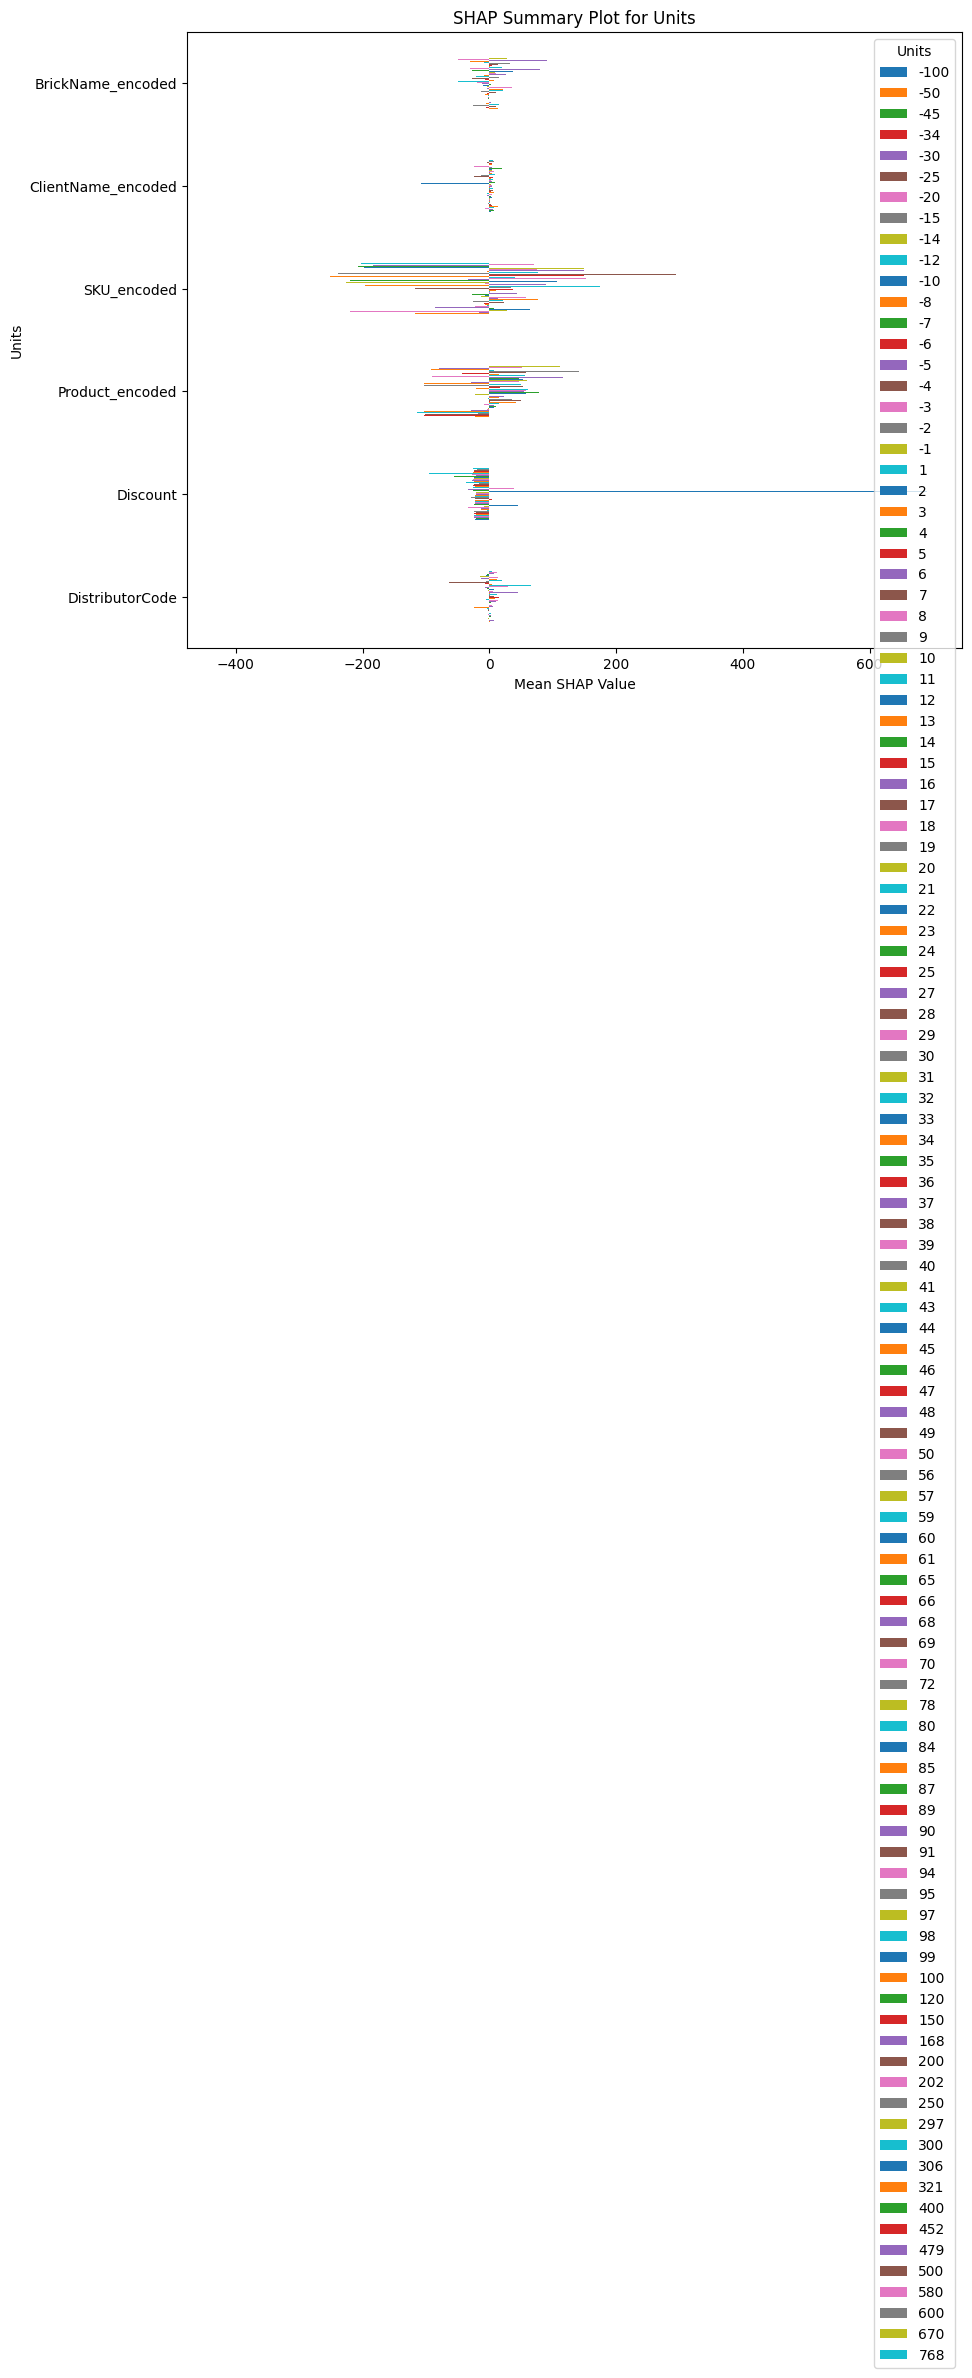

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [ ]:
# Create a DataFrame for SHAP values with product names
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["Units"] = df_order["Units"]

# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("Units").mean()

# Plot the SHAP summary for each product
shap_summary.T.plot(kind='barh', figsize=(10, 8))
plt.title('SHAP Summary Plot for Units')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Units')
plt.show()

fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for Units ',
             labels={'value': 'Mean SHAP Value', 'Units': 'Units'})

# Show the plot
fig.show()



In [ ]:

#  DataFrame for SHAP values with product names
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["ValueNp"] = df_order["ValueNp"]

# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("ValueNp").mean()

fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for ValueNp',
             labels={'value': 'Mean SHAP Value', 'ValueNp': 'ValueNp'})

# Show the plot
fig.show()



/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

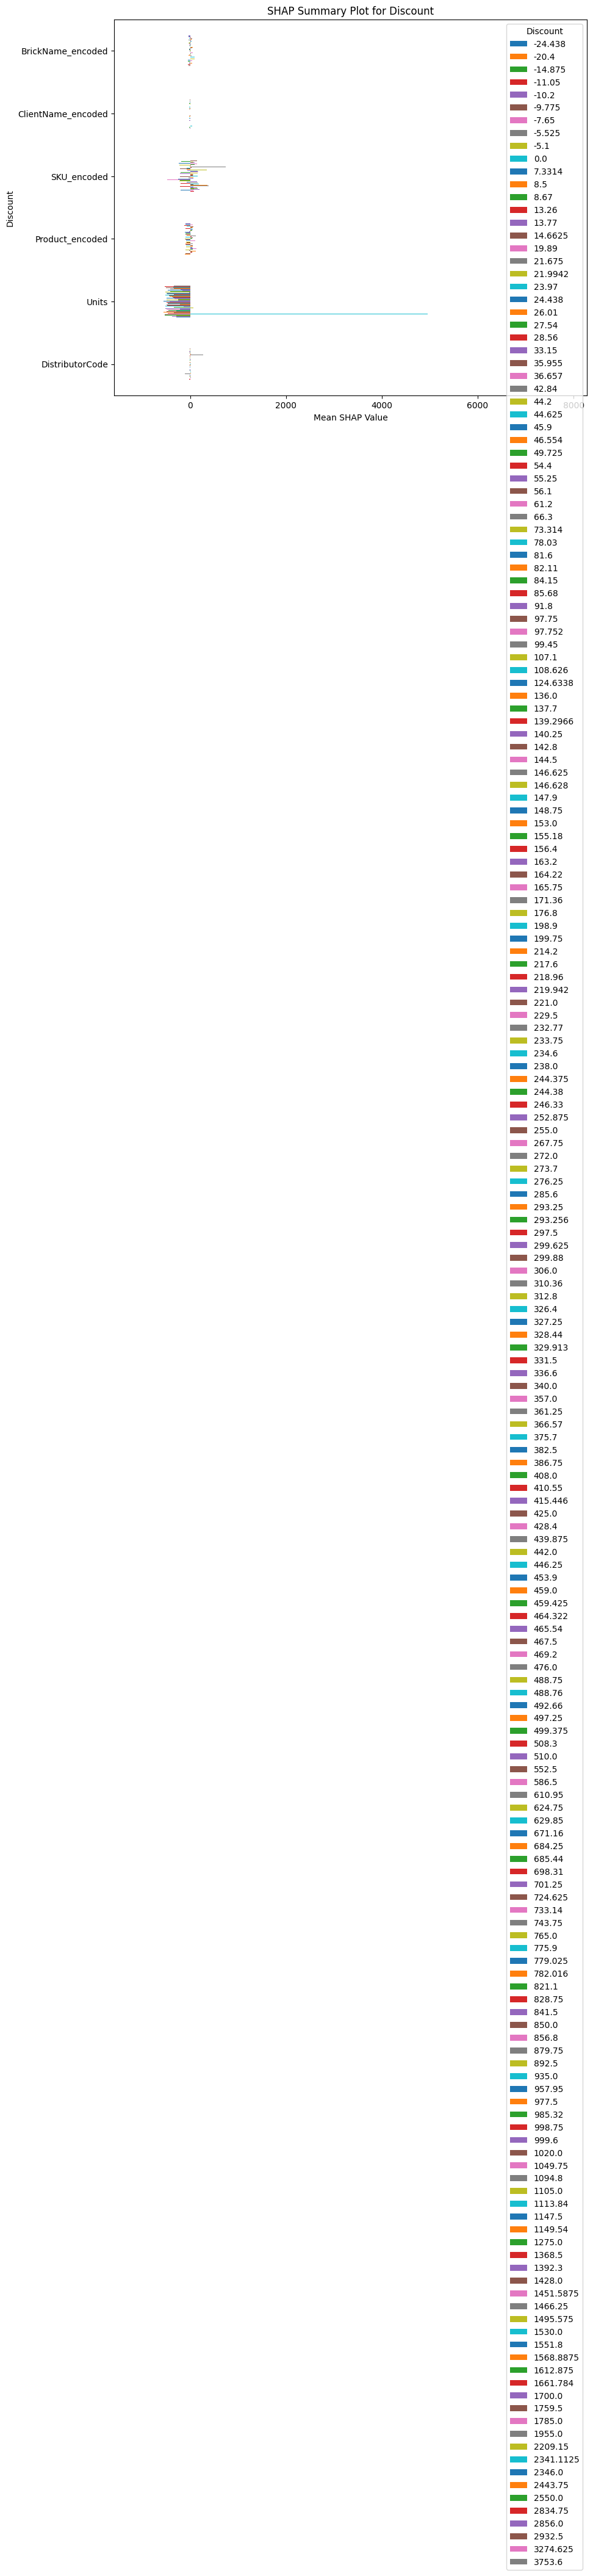

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [ ]:
# ValueNp
# Discount
# Create a DataFrame for SHAP values with product names
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["Discount"] = df_order["Discount"]

# Group by product and calculate the mean SHAP value for each
shap_summary = shap_df.groupby("Discount").mean()

# Plot the SHAP summary for each product
shap_summary.T.plot(kind='barh', figsize=(10, 8))
plt.title('SHAP Summary Plot for Discount')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Discount')
plt.show()

fig = px.bar(shap_summary.T, orientation='h', title='SHAP Summary Plot for Discount',
             labels={'value': 'Mean SHAP Value', 'ValueNp': 'Discount'})

# Show the plot
fig.show()



In [ ]:
df_order = pd.read_csv('sales_data.csv')
df_order.head()

DistributorCode               DistributorName  ClientCode  \
0             2715  Premier Agencies - HYDERABAD     3129643   
1             2715  Premier Agencies - HYDERABAD     1301969   
2             2715  Premier Agencies - HYDERABAD     1301971   
3             2715  Premier Agencies - HYDERABAD     1466465   
4             2715  Premier Agencies - HYDERABAD     1301976   

                                          ClientName  \
0  STAR MEDICAL STORE/HIRABAD/HIRABAD-HIRABAD-AZA...   
1  BHITAI MEDICAL STORE/BIHAR COLONY HOSRI/HOSRI-...   
2  SARFARAZ MEDICAL STORE/HOSRI PUL PAR/HOSRI-HOS...   
3  MEHRAN MEDICAL STORE/HOSRI PUL PAR/HOSRI-HOSRI...   
4  RANA MUKESH MEDICAL STORE/HOSRI PUL PAR/HOSRI-...   

                                    BrickName  Product          SKU  \
0  HIRABAD-HIRABAD-AZAD MEEZAN MASJID HIRABAD  Prod-NS  Prod-NS-Tab   
1              HOSRI-HOSRI-BIHAR COLONY HOSRI  Prod-NS  Prod-NS-Tab   
2                  HOSRI-HOSRI-HOSRI PULL PAR  Prod-NS  Prod-NS-Tab   
3                  HOSRI-HOSRI-HOSRI PULL PAR  Prod-NS  Prod-NS-Tab   
4                  HOSRI-HOSRI-HOSRI PULL PAR  Prod-NS  Prod-NS-Tab   

  InvoiceDate  Units  Bonus  Discount  ValueNp  
0    4/1/2017      1      0       0.0    97.75  
1    4/1/2017      3      0       0.0   293.25  
2    4/1/2017      2      0       0.0   195.50  
3    4/1/2017      2      0       0.0   195.50  
4    4/1/2017      1      0       0.0    97.75

In [ ]:
drop = ['DistributorName','ClientCode', 'ClientName', 'BrickName', 'Product', 'SKU', 'Bonus']
df_order = df_order.drop(columns=drop, inplace=False)

df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290514 entries, 0 to 290513
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DistributorCode     290514 non-null  int64  
 1   InvoiceDate         290514 non-null  object 
 2   Units               290514 non-null  int64  
 3   Discount            290514 non-null  float64
 4   ValueNp             290514 non-null  float64
 5   Product_encoded     290514 non-null  int64  
 6   SKU_encoded         290514 non-null  float64
 7   ClientName_encoded  290514 non-null  int64  
 8   BrickName_encoded   290514 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 19.9+ MB


# ENSEMBLE Learning

In [ ]:
df_order.set_index('InvoiceDate', inplace=True)
df_order.sort_values('InvoiceDate', inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df_order_scaled = df_order.copy()

# Drop columns from df_order_scaled
columns_to_drop = ['DistributorCode', 'Product_encoded','ClientName_encoded', 'BrickName_encoded', 'SKU_encoded']
df_order_scaled = df_order_scaled.drop(columns=columns_to_drop)

df_order_scaled.info()


<class 'pandas.core.frame.DataFrame'>
Index: 290514 entries, 1/1/2017 to 9/9/2017
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Units     290514 non-null  int64  
 1   Discount  290514 non-null  float64
 2   ValueNp   290514 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 8.9+ MB


In [ ]:

# Select columns to scale
columns_to_scale = ['Units', 'Discount', 'ValueNp']

# Apply Min-Max scaling
scaler = MinMaxScaler()
df_order_scaled[columns_to_scale] = scaler.fit_transform(df_order_scaled[columns_to_scale])

df_order_scaled.head()



Units  Discount   ValueNp
InvoiceDate                              
1/1/2017     0.136216   0.21569  0.207213
1/1/2017     0.137297   0.21569  0.209699
1/1/2017     0.137297   0.21569  0.209699
1/1/2017     0.137297   0.21569  0.209699
1/1/2017     0.141622   0.21569  0.219262

In [ ]:
drop = ['ValueNp', 'Discount', 'Units']
df_order = df_order.drop(columns=drop, inplace=False)


In [ ]:

df_combined = pd.concat([df_order, df_order_scaled[columns_to_scale]], axis=1)

# print(df_combined)
df_combined.head()

DistributorCode  Product_encoded  SKU_encoded  \
InvoiceDate                                                  
1/1/2017                   1                3          3.5   
1/1/2017                   1                2          2.3   
1/1/2017                   1                2          2.3   
1/1/2017                   1                2          2.3   
1/1/2017                   1                2          2.3   

             ClientName_encoded  BrickName_encoded     Units  Discount  \
InvoiceDate                                                              
1/1/2017                   2070                250  0.136216   0.21569   
1/1/2017                   2693                299  0.137297   0.21569   
1/1/2017                   2593                299  0.137297   0.21569   
1/1/2017                   3260                315  0.137297   0.21569   
1/1/2017                   2694                316  0.141622   0.21569   

              ValueNp  
InvoiceDate            
1/1/2017     0.207213  
1/1/2017     0.209699  
1/1/2017     0.209699  
1/1/2017     0.209699  
1/1/2017     0.219262

In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290514 entries, 1/1/2017 to 9/9/2017
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DistributorCode     290514 non-null  int64  
 1   Product_encoded     290514 non-null  int64  
 2   SKU_encoded         290514 non-null  float64
 3   ClientName_encoded  290514 non-null  int64  
 4   BrickName_encoded   290514 non-null  int64  
 5   Units               290514 non-null  float64
 6   Discount            290514 non-null  float64
 7   ValueNp             290514 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 19.9+ MB


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import shap

# Split data into training and testing sets
train_data, test_data = train_test_split(df_combined, test_size=0.2, random_state=42)

# Define Multiple Regression Models
rf_model = RandomForestRegressor(n_estimators=3000, random_state=42)
gbt_model = GradientBoostingRegressor(n_estimators=1000, random_state=42)

# Create a Voting Regressor
ensemble_model = VotingRegressor(estimators=[('rf', rf_model), ('gbt', gbt_model)])

# Fit the Ensemble Model
ensemble_model.fit(train_data.drop('ValueNp', axis=1), train_data['ValueNp'])



VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(n_estimators=3000,
                                                   random_state=42)),
                            ('gbt',
                             GradientBoostingRegressor(n_estimators=1000,
                                                       random_state=42))])

In [ ]:
# Make Predictions
predictions = ensemble_model.predict(test_data.drop('ValueNp', axis=1))

# Evaluate the Model
mse = mean_squared_error(test_data['ValueNp'], predictions)
mae = mean_absolute_error(test_data['ValueNp'], predictions)
r_squared = r2_score(test_data['ValueNp'], predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared: {r_squared:.4f}")


Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0003
R-squared: 0.9928


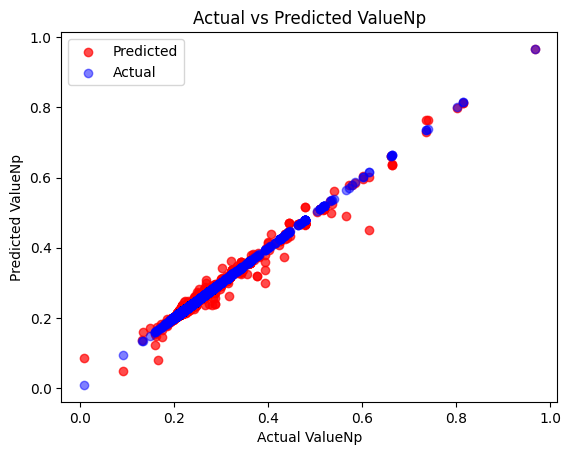

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs predicted values with blue for actual and red for predicted
plt.scatter(test_data['ValueNp'], predictions, label='Predicted', color='red', alpha=0.7)
plt.scatter(test_data['ValueNp'], test_data['ValueNp'], label='Actual', color='blue', alpha=0.5)

plt.xlabel('Actual ValueNp')
plt.ylabel('Predicted ValueNp')
plt.title('Actual vs Predicted ValueNp')
plt.legend()
plt.show()


In [ ]:

# Combine actual and predicted values into a DataFrame for better display
results_df = pd.DataFrame({
    'Actual': test_data['ValueNp'].values,
    'Predicted': predictions
})

# Print the actual and predicted values
print(results_df)


         Actual  Predicted
0      0.221311   0.220446
1      0.209734   0.209806
2      0.207650   0.207605
3      0.206489   0.206466
4      0.208128   0.208001
...         ...        ...
58098  0.206489   0.206479
58099  0.205704   0.205704
58100  0.211516   0.211547
58101  0.207213   0.207274
58102  0.209631   0.209679

[58103 rows x 2 columns]


# The END